<font size="6">****Descriptive and predictive analysis of COVID-19 data****</font> 
<br>
<br>
<font size="3">****Table of Contents****</font>  
1. [Introduction](#introduction)
2. [Theoretical framework](#theoretical_framework)  
&nbsp;&nbsp;&nbsp;2.1 [The SIRF model](#the_sirf_model)  
&nbsp;&nbsp;&nbsp;2.2 [Parameters and ordinary differential equations](#parameters_and_ordinary_differential_equations)  
&nbsp;&nbsp;&nbsp;2.3 [Parameter variation](#parameter_variation)  
&nbsp;&nbsp;&nbsp;2.4 [Parameter hyperestimation](#parameter_hyperestimation)  
3. [Empirical analysis](#empirical_analysis)  
&nbsp;&nbsp;&nbsp;3.1 [Data](#data)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.1 [Data sources, variables description and sample construction](#data_sources_variables_description_and_sample_construction)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.2 [Descriptive statistics](#descriptive_statistics)  
&nbsp;&nbsp;&nbsp;3.2 [SIRF model parameter estimation and visualization](#sirf_model_parameter_estimation_and_visualization)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 [Parameter estimation](#parameter_estimation)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 [Data inspection](#data_inspection)  
&nbsp;&nbsp;&nbsp;3.3 [Effect of government quality on efficacy of government intervention](#effect_of_government_quality_on_efficacy_of_government_intervention)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.1 [Set-up](#setup)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.2 [Multiple linear regression model](#multiple_linear_regression_model)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.3 [Multiple linear regression model with continent fixed effects](#multiple_linear_regression_model_with_continent_fixed_effects)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.4 [Multiple linear regression model with interaction effects](#multiple_linear_regression_model_with_interaction_effects)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.5 [Regression diagnostics](#regression_diagnostics)  
&nbsp;&nbsp;&nbsp;3.4 [Scenario analysis](#scenario_analysis)  
4. [Conclusion](#conclusion)  

<a id="introduction"></a>
# Introduction

The sudden and unexpected emergence of the novel coronavirus in December 2019 caused severe adverse effects on economies and public health around the world from early 2020 to the present day (see, e.g., [Chudik, Mohaddes, Hashem et al. (2020)](https://www.nber.org/papers/w27855) and ([Huang, Huang, Wang et al. (2021)](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)32656-8/fulltext)). Two effective ways to dampen the spread of the coronavirus are government interventions (see, e.g., [Haug, Geyrhofer, Londei et al. (2020)](https://www.nature.com/articles/s41562-020-01009-0)) and vaccines (see, e.g., [Rossman, Shilo, Meir et al. (2021)](https://www.nature.com/articles/s41591-021-01337-2)). 

In this study, we investigate the effect of government quality on the efficacy of government interventions and predict the impact of a lockdown, medicine and vaccine scenario on several coronavirus-related variables, such as confirmed or fatal cases. To identify these effects, we collect daily panel data on 199 countries, employ the SIRF model, which is a workhorse model for explaining infectious diseases, and run regressions. We find that the government quality variable informal payments to officials significantly decreases and frequency of publication of key socioeconomic indicators signficantly increases the efficacy of government interventions. The scenario analysis shows that a lockdown, medicines or vaccines in May 2021 would significantly reduce the number of coronavirus cases and deaths in Switzerland over the next 360 days.

The remainder of this paper is structured as follows. In section 2, we introduce the SIRF model. Section 3 provides descriptive statistics on the coronavirus pandemic and presents the empirical results from the regressions and scenario analysis. Section 4 concludes.

**Import of modules**

In [31]:
import covsirphy as cs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import os
import pycountry as pyc
import pycountry_convert as pc
import random
import statsmodels.formula.api as smf
import statsmodels.api as sm
import wbgapi as wb
import seabornfig2grid as sfg
import matplotlib.gridspec as gridspec
import geopandas as gpd
import mapclassify
from tqdm import tqdm
from datetime import timedelta
from datetime import datetime
from scipy import stats
from scipy.integrate import odeint
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import FormatStrFormatter
from covid19dh import covid19
from IPython.display import display
from IPython.display import Image
pd.options.mode.chained_assignment = None 

<a id='theoretical_framework'></a>
# Theoretical framework

The following section presents the theoretical concepts that are required to understand the empirical analysis in this paper. Specifically, this section introduces the SIRF model as a compartmental framework for modelling a pandemic. Moreover, particular attention is paid to the meaning and estimation of the model parameters. Finally, we provide a primer on the error measures that will be used to evaluate the model accuracy.

<a id='the_sirf_model'></a>
## The SIRF model

The SIRF model is a compartmental model belonging to a family of mathematical frameworks that model infectious diseases, such as pandemics. The SIRF model assigns individuals of a population to different compartments. Individuals either stay in a compartment for a certain amount of time or they progress between compartments. The transition between compartments is modelled by using ordinary differential equations. These equations suppose that the spread of a disease follows certain rules, which makes the development of a pandemic deterministic. Under the assumption that the rules of this model hold, it is possible to estimate important epidemiological parameters, such as the total number of susceptible, infected or recovered people, as well as crucial indicators, such as the reproductive number or the death rate. These types of models can serve as a basis for deriving recommendations for governmental public health interventions, which can affect the development of the epidemic. The SIRF model, as one of the simplest but most useful models, consists of four mutually exclusive and collectively exhaustive compartments of one population, which categorize people as of a particular point in time.

**Compartmental states**
- **Susceptible** ($S$): The number of susceptible individuals.
- **Uncategorized** ($U$): The number of infected and unconfirmed individuals.
- **Infected** ($I$): The number of infected and confirmed individuals.
- **Recovered** ($R$): The number of recovered and immune individuals.
- **Fatal** ($F$): The number of deceased individuals.

The predictive power of the SIRF model stems from the construction of an equation system that determines the transition between compartments over time. Consequently, the model assumes the progress of individuals between compartments to be dependent on transition rates which makes the stock of each compartment a function of the variable time ($t$). The flow of individuals between states can be illustrated as follows.

\begin{align*}
\large\mathrm{S} \overset{\beta I}{\longrightarrow}\mathrm{U}\overset{\alpha_1}{\longrightarrow}\ & \large\mathrm{F}    \\
\large\mathrm{U}\overset{1 - \alpha_1}{\longrightarrow}\ & \large\mathrm{I}\overset{\gamma}{\longrightarrow}\mathrm{R}    \\
& \large \mathrm{I}\overset{\alpha_2}{\longrightarrow}\mathrm{F}    \\
\end{align*}

**Endemic steady state**  
In epidemiology, an infection is said to be in an endemic steady state when the number of infected individuals is maintained at a constant level over time. It implies that one infectious individual must transmit the disease to one other person on average, hence the reproduction number equals $R_{0}=1$. In cases where a proportion of the population has already been immunized either because they were already infected or they were vaccinated, the critical condition for an endemic steady state transfers to $R_{0}*S=1$. Thereby, the size of the infected compartment remains constant. From a regulatory perspective, we assume that the steady state represents a critical condition which must not be exceeded. By making this assumption, we can evaluate the costs and benefits associated with governmental interventions.

<a id="parameters_and_ordinary_differential_equation_system"></a>
## Parameters and ordinary differential equation system

**Parameter definitions**  
- **Effective contact rate** ($\beta$): The rate of effective infection [1/min].
- **Recovery rate** ($\gamma$): The recovery probability of infected and confirmed individuals [1/min].
- **Mortality rate of uncategorized individuals** ($\alpha_{1}$): The fatality probability of infected and unconfirmed individuals [1/min].
- **Mortality rate of infected individuals** ($\alpha_{2}$): The fatality probability of infected and confirmed individuals [1/min].
- **Discretizer** ($\tau$): Length of discrete time intervals [min].

**Reproduction number**  
The reproduction number of an infection, $R_{0}$, is the expected number of transmissions that are directly generated by one infectious individual in a population. $R_{0}>1$ indicates that the disease will be able to spread in a population. By contrast, when $R_{0}<1$, the number of infected individuals decreases. The reproduction number can be expressed by the following formula.

$R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}$

The reproduction number allows to determine the proportion of the population that should be immunized through vaccination to eradicate a disease. To prevent the spread, the proportion of a population that needs to be effectively vaccinated must be larger than $1-\frac{1}{R_{0}}$. Conversely, the proportion of the population that remains susceptible to the disease should be smaller than $\frac{1}{R_0}$.

**Ordinary differential equations**  
Under the assumption that the size of a compartmental state is differentiable with respect to time, the epidemic process becomes deterministic. Consequently, we can model the development of an epidemic by using the following set of ordinary differential equations.

\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

where $N=S+I+R+F$ represents the total population and $T$ describes the elapsed time from the start date.

**Parameter proxies**  
With the estimation of parameters, we introduce the following proxies.

- Set $(S, I, R, F) = N \times (x, y, z, w)$
- Set $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$  

whereby the parameters are defined within the following ranges.  
- $0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1$
- $1\leq \tau \leq 1440$

**Programmatic implementation**  
The system of ordinary differential equations can be easily implemented in Python code. In order to do so, we define a function called `deriv` which generates the corresponding derivatives of each compartment as of a specific point in time.

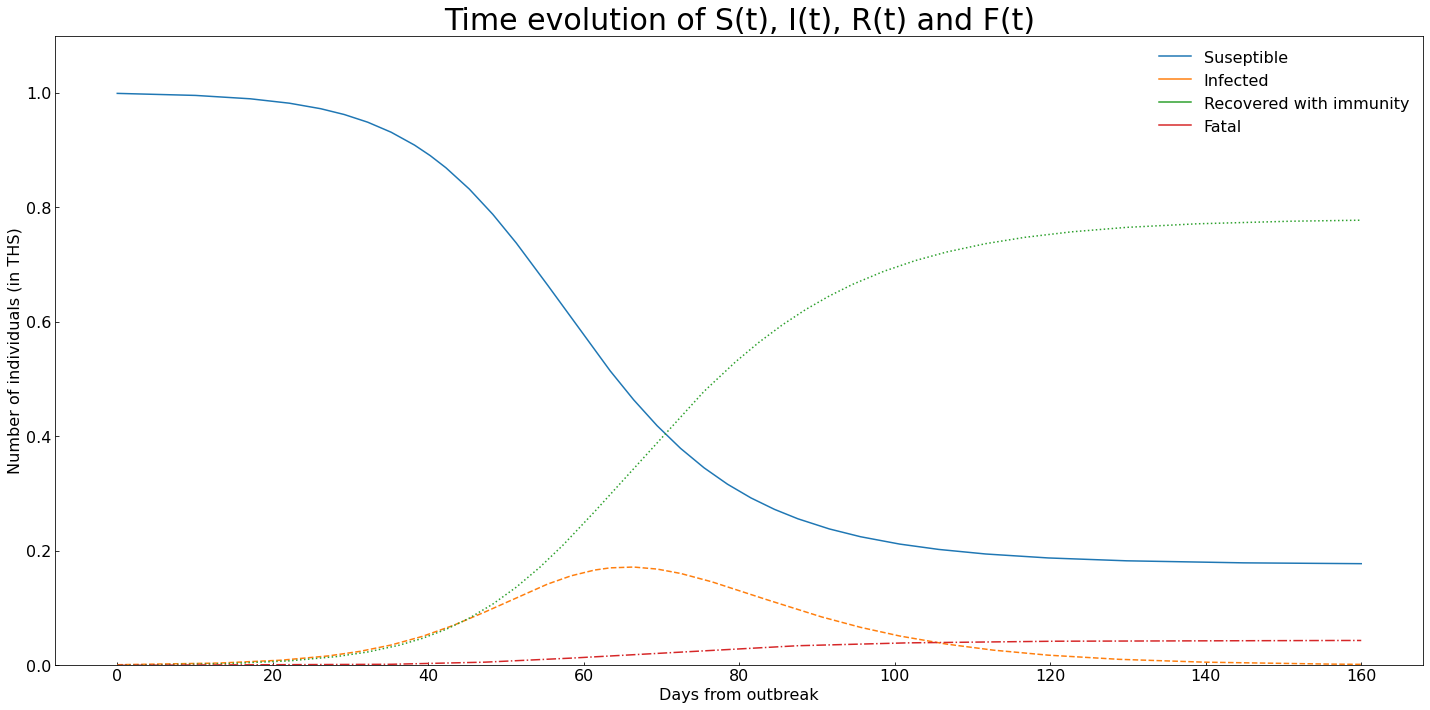

In [32]:
# Total population, N.
N = 1000

# Initial number of infected, recovered and fatal individuals.
I0, R0, F0 = 1, 0, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - F0

# Effective contact rate, BETA, and mean recovery rate, GAMMA, (in 1/days).
ALPHA_1, ALPHA_2, BETA, GAMMA = .0002, .005, 0.2, .09 

# A grid of time points (in days).
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, ALPHA_1, ALPHA_2, BETA, GAMMA):
    S, I, R, F = y
    dSdt = -(N ** -1 * BETA * S * I)
    dIdt = N ** -1 * (1 - ALPHA_1) * BETA * S * I - (GAMMA + ALPHA_2) * I
    dRdt = GAMMA * I
    dFdt = N ** -1 * ALPHA_1 * BETA * S * I + ALPHA_2 * I
    return dSdt, dIdt, dRdt, dFdt

# Initial conditions vector
y0 = S0, I0, R0, F0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, ALPHA_1, ALPHA_2, BETA, GAMMA))
S, I, R, F = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x = t, y = S/1000, label='Suseptible')
sns.lineplot(x = t, y = I/1000, label='Infected')
sns.lineplot(x = t, y = R/1000, label='Recovered with immunity')
sns.lineplot(x = t, y = F/1000, label='Fatal')

# Add figure annotations
ax.set_title('Time evolution of S(t), I(t), R(t) and F(t)', fontdict={'fontsize': 30})
ax.set_xlabel('Days from outbreak', fontsize=16)
ax.set_ylabel('Number of individuals (in THS)', fontsize=16)
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

ax.lines[0].set_linestyle('solid')
ax.lines[1].set_linestyle('dashed')
ax.lines[2].set_linestyle('dotted')
ax.lines[3].set_linestyle('dashdot')

plt.tight_layout()

<a id="parameter_variation"></a>
## Parameter variation

To illustrate how the epidemic process is influenced by the parameters of the model, the following section will provide four scenarios and plot the results.

**Examplary scenarios**
- **Mortality rate of uncategorized**: $(\theta, \kappa, \rho, \sigma) = (0.0600, 0.005, 0.20, 0.075)$
- **Mortality rate of infected**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.050, 0.20, 0.075)$
- **Effective contact rate**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.40, 0.075)$
- **Recovery rate**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.140)$

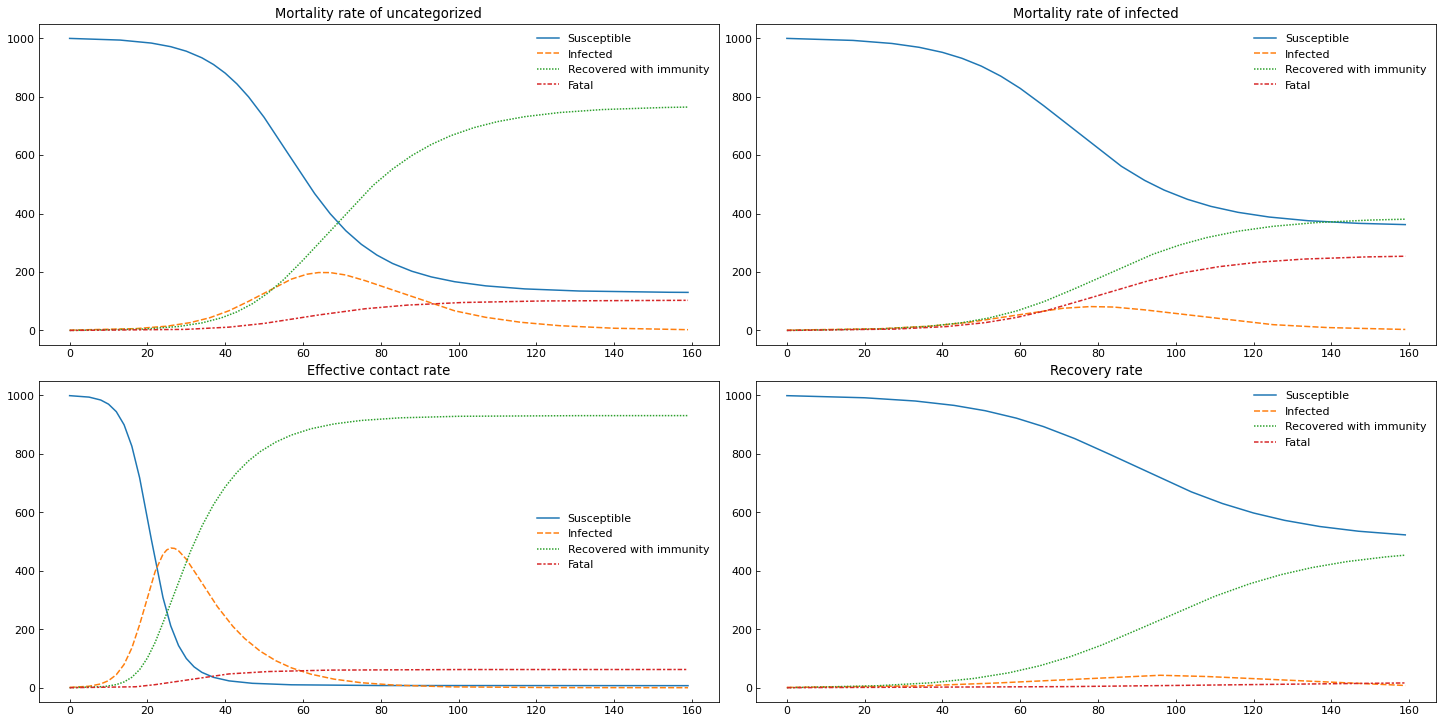

In [33]:
scenarios = {'Mortality rate of uncategorized':  (0.0600, 0.005, 0.20, 0.075),
             'Mortality rate of infected':       (0.0002, 0.050, 0.20, 0.075),
             'Effective contact rate':           (0.0002, 0.005, 0.40, 0.075),
             'Recovery rate':                    (0.0002, 0.005, 0.20, 0.140)}

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20,10))

for iIteration, iScenario in enumerate(scenarios):
    ALPHA_1, ALPHA_2, BETA, GAMMA = scenarios[iScenario]
    ret = odeint(deriv, y0, t, args=(N, ALPHA_1, ALPHA_2, BETA, GAMMA))
    df = pd.DataFrame(ret, columns=['Susceptible', 'Infected', 'Recovered with immunity', 'Fatal'])    
    sns.lineplot(data=df, ax=eval(f'ax{iIteration}'))
    eval(f"ax{iIteration}.set_title('{iScenario}')")

fig.tight_layout(pad=0.5)

**The mortality rate of uncategorized individuals** ($\theta$)  
We observe that an increase in mortality rates of uncategorized individuals has only a limited impact on fatal cases. The reason for this insignificant effect is that mortality rates of uncategorized individuals are low by assumption. Most of COVID-19 deaths can be attributed to a previous confirmed infection, and hence also a large percentual increase of uncategorized mortality does not significantly impact total fatal cases.

**The mortality rate of infected individuals** ($\kappa$)  
An increase in mortality rates of infected individuals seems to invoke larger changes in the dynamics of the model. First, individuals which are in the infected compartment experience a greater probability of dying rather than recovering. Hence, the model transfers individuals from the recovered compartment to the fatal compartment. Second, it seems that an increased mortality rate has a positive effect on the number of susceptible individuals. This is the case because a disease cannot spread through the entire population if its mortality rate is high, as infected individuals do not transfer the disease but die.

**Effective contact rate** ($\rho$)  
An increase in the effective contact rate increases the probability of the disease to be transmitted from infected to susceptible individuals. Hence, the magnitude of individuals in the infected compartment increases significantly. At the same time, the number of susceptible individuals decreases and the number of recovered individuals increases. This results in a population being entirely immunized against a disease because the largest part of the population has been infected but recovered successfully. In this case the proportion of immunized individuals will soon be large enough to dampen the spread of a disease and achieve the so-called herd immunity. The effective contact rate is largely determined by social contact patterns of a particular society, hence government restrictions can have a meaningful influence on the spread of the epidemic process.

**Recovery rate** ($\sigma$)  
An increase in recovery rates results in a higher probability of individuals to recover from a disease. Hence, individuals are transferred from the fatal compartment to the recovered compartment.

**Effect of specific scenarios on model parameters**  
Government measures have a significant impact on the parameters of the model. For our simulations, we assume the following relationships.
- **Lockdown**: A lockdown scenario halves the effective contact rate because individuals are required to limit social contact patterns.
- **Medicine**: A medicine scenario reduces the mortality rate of infected individuals and increases the recovery rate at the same time.
- **Vaccine**: A vaccine scenario reduces the effective contact rate, reduces the mortality rate of infected individuals and increases the recovery rate.

The following figure summarizes the impact of specific scenarios on model parameters.

| Scenario | Parameter change                                   |
|----------|----------------------------------------------------|
| Lockdown | $\rho * 0.5$                                       |
| Medicine | $\kappa * 0.5$ and $\sigma * 2$                    |
| Vaccine  | $\rho * 0.8$ and $\kappa * 0.6$ and $\sigma * 1.2$ |

<a id="parameter_hyperestimation"></a>
## Parameter hyperestimation

For the estimation of the model parameters, the relationship between susceptible ($S$) and recovered ($R$) individuals determines the parameter values. Parameter optimization occurs within certain time phases in which the flow from the initial compartment ($S$) to the final compartment ($R$) is constant. The Root Mean Squared Log Error (RMSLE) shown below serves as the relevant cost function for the optimization algorithm.

$$ \text{RMSLE} = \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2} $$

where 
- $A$ is observed (actual) values
- $P$ is estimated (predicted) values. 
- Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for the SIRF model. 

By applying the RMSLE, prediction errors are not penalized much more severly in cases where the predicted and actual values are large numbers. This is the case because the RMSLE focuses on the relative error between the predicted and actual values, hence the scale of the error is insignificant. At the same time, the biasing effect of outliers is drastically reduced. A second point for why this metric is advantageous for the computations at hand is that the RSMLE imposes a biased error. The RMSLE incurs stricter penalties for underestimation than for overestimation, which is particularly useful for the analysis of COVID-19 data where overestimating the target variable, such as the number of coronavirus cases, is often preferred over underestimating it.

For a more detailed description of the optimization algorithm, see the paper from ([Balkew and Mogessie (2010)](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd)).

<a id="empirical_analysis"></a>
# Empirical analysis

<a id="data"></a>
## Data

<a id="data_sources_variables_description_and_sample_construction"></a>
### Data sources, variables description and sample construction

Our main dataset consists of daily panel data on 199 countries and stems from the COVID-19 Data Hub ([Guidotti and Ardia (2020)](https://covid19datahub.io)). The dataset includes various COVID-19 variables, such as the cumulative number of confirmed cases and deaths, and information on policy measures and geography of each country. One important variable that will be used in the parameter estimation section is the stringency index. This variable is between 0 and 100 and measures the stringency of the COVID-19 government measures. A higher stringency index means more severe government measures. In this section, we work solely with the COVID-19 Data Hub dataset (C19DH), while in the regression and scenario analysis sections, we employ the [CovsirPhy](https://lisphilar.github.io/covid19-sir/index.html) package which is based primarily on the C19DH and data on the number of tests and vaccinations from Our World in Data ([Hasell, Mathieu and Beltekian (2020)](https://github.com/owid/covid-19-data/tree/master/public/data)). For the government quality variables, we use the QoG Expert Survey from the University of Gothenburg. This dataset is described in more detail in the section where the regressions are run.

Before we can import the C19DH, we have to set the working directory and paths. The BASE_PATH has to point to the covid19_project folder.

In [ ]:
BASE_PATH = r'C:\Users\Stephan\Documents\covid19_project'
os.chdir(BASE_PATH)
RAW_DATA_PATH = BASE_PATH + '\\data\\raw_data'
CLEAN_DATA_PATH = BASE_PATH + '\\data\\clean_data'
OUTPUT_PATH = BASE_PATH + '\\output'

Now we import the variables of interest of the raw C19DH and display the first five observations of France and the United States. 

In [9]:
rawCovidData = pd.read_csv(RAW_DATA_PATH + '\\covid19_dataset.csv', na_values=['NaN'], parse_dates=['date'], 
                           usecols=['id', 'date', 'confirmed', 'deaths', 'population', 'administrative_area_level_1'])

display(rawCovidData.loc[rawCovidData['id'] == 'FRA'].head())
display(rawCovidData.loc[rawCovidData['id'] == 'USA'].head())

,id,date,confirmed,deaths,population,administrative_area_level_1
30470,FRA,2020-01-22,NaN,NaN,66977107,France
30471,FRA,2020-01-23,1.0,NaN,66977107,France
30472,FRA,2020-01-24,3.0,NaN,66977107,France
30473,FRA,2020-01-25,3.0,NaN,66977107,France
30474,FRA,2020-01-26,3.0,NaN,66977107,France


,id,date,confirmed,deaths,population,administrative_area_level_1
91328,USA,2020-01-22,1.0,NaN,326687501,United States
91329,USA,2020-01-23,1.0,NaN,326687501,United States
91330,USA,2020-01-24,2.0,NaN,326687501,United States
91331,USA,2020-01-25,2.0,NaN,326687501,United States
91332,USA,2020-01-26,5.0,NaN,326687501,United States


As can be seen, our subdataset of the C19DH contains for every country daily information on the cumulative confirmed cases and deaths as well as population size. Note that we use a static version of the raw C19DH dataset to ensure that our results can be reproduced. We downloaded and exported the C19DH with the following two commands.

In [10]:
# rawCovidData = covid19(raw=True, verbose=False)[0]
# rawCovidData.to_csv(RAW_DATA_PATH + '\\covid19_dataset.csv', na_rep='NaN', index=False)

In the remainder of this section, we clean the data and perform various sanity checks.

Sanity check 1: All variables have the correct data type.

In [11]:
rawCovidData.dtypes

id                                     object
date                           datetime64[ns]
confirmed                             float64
deaths                                float64
population                              int64
administrative_area_level_1            object
dtype: object

Next, we rename the variables id and administrative_area_level_1 to make their meaning clearer.

In [12]:
rawCovidData = rawCovidData.rename(columns={'id':'country', 'administrative_area_level_1':'countryLong'})

Sanity check 2: The variables country, date and countryLong, which are used as the main identifiers for the observations,
do not contain any missing values.

In [13]:
if rawCovidData[['country', 'date', 'countryLong']].isnull().any(axis=None):
    raise ValueError('The variable country, date or countryLong contains missing values.')

Now we choose the sample period. We extract the observation(s) with the earliest date (1 January 2020) and most recent date (27 May 2021). To mitigate the effect of lags in reporting of COVID-19 statistics across countries and to end the sample period on a Sunday, we cut off the last 11 days. Hence, our sample period is from 1 January 2020 to 16 May 2021. 

In [14]:
startDate = rawCovidData['date'].loc[rawCovidData['date'] == rawCovidData['date'].min()].iloc[0] 
endDate = rawCovidData['date'].loc[rawCovidData['date'] == rawCovidData['date'].max()].iloc[0] - pd.Timedelta(11, unit='d')
rawCovidData = rawCovidData.loc[(rawCovidData['date'] >= startDate) & (rawCovidData['date'] <= endDate)]

Next, we find that the C19DH is an unbalanced panel, which means that the number of observations differs across countries. The following table displays the relative frequency of the number of observations per country. Note that the variable date does not contain any NaT values. Hence, count() returns the number of observations per country.

In [15]:
rawCovidData[['country','date']].groupby(by=['country']).count().value_counts(normalize=True)

date
481     0.969849
430     0.005025
478     0.005025
483     0.005025
488     0.005025
500     0.005025
502     0.005025
dtype: float64

As can be seen, most countries (97%) have 481 observations. There are, however, a few countries with a different number of observations. To make the data analysis more consistent across countries, we will create a balanced panel in the next step.
Note that according to the data supplier, one could also use the option raw=False when downloading the data. This option automatically creates a balanced panel and replaces all missing values with zero or the previous non-NaN value. Unfortunately, the pre-processed data is only available until the 1 April 2021. Hence, we do the data cleaning ourselves.

In [16]:
# Creation of a balanced panel dataset.
            
# dateList consists of all dates in the sample period and countryList
# contains all unique countries that exist in the dataset.
dateList = pd.date_range(startDate, endDate, freq='d')
countryList = rawCovidData['country'].unique()

# The following loop appends the missing observations to the dataset.
for iIteration, iCountry in enumerate(countryList):
    
    # Get data of country iCountry.
    iCountryData = rawCovidData.loc[rawCovidData['country'] == iCountry]
    
    # If for country iCountry an observation is missing, I create the observation 
    # and then append it to the dataset.
    for iDate in dateList:
        
        if iDate not in iCountryData['date'].values:
            
            missingObs = pd.DataFrame([[iCountry, iDate, np.nan, np.nan, iCountryData.iloc[0,4],
                                        iCountryData.iloc[0,5]]], columns=list(rawCovidData.columns.values))
            
            rawCovidData = rawCovidData.append(missingObs)

Next, I sort the data in ascending order by country and date and set a multiindex.

In [17]:
rawCovidData = rawCovidData.sort_values(by=['country', 'date'], ascending=[True, True])
rawCovidData = rawCovidData.set_index(['country', 'date'])

Sanity check 3: The C19DH is now a balanced panel.

In [18]:
if len(rawCovidData['countryLong'].groupby(level=0).count().unique()) != 1:
    raise ValueError('The dataset is an unbalanced panel.')

Sanity check 4: Each observation has a unique index (country + date).

In [19]:
if not(rawCovidData.index.is_unique):
    raise IndexError('Indices do not uniquely identify each observation.')

Now we analyse and replace the missing data in the C19DH. The following loop replaces all missing values that occur before the first non-NaN value with zero in the confirmed cases and deaths variables. We assume that these missing values are zero because they occur at the beginning of the pandemic when no cases or deaths were observed by the countries. Moreover, the loop lists all countries for which more than 1% truly missing values exist in the confirmed cases and deaths variables. We define a value as truly missing if the missing value occurs between the first and last non-Nan value of a variable. 

In [20]:
# Replacement and analysis of missing values.

# To replace and analyse the missing values efficiently, we use a numeric index variable in rawCovidData.
rawCovidData['indices'] = range(0, rawCovidData.shape[0]) 
variableList = ['confirmed', 'deaths']
printTitle = True

for iCountry in countryList:

    # Get data of country iCountry.
    iCountryData = rawCovidData.loc[rawCovidData.index.get_level_values('country') == iCountry]
    
    # This loop replaces all missing values that occur before the first non-Nan value with zero.
    for iVariable in variableList:
        
        # If the first value of the variable iVariable is not a NaN, 
        # then we do not replace any missing values with zero.
        if ~np.isnan(iCountryData[iVariable].iloc[0]):
            continue
        
        # If all values of variable iVariable are NaNs, then we replace all of them with zero.
        if iCountryData[iVariable].isnull().all():
            # Obtain index of last observation of country iCountry in rawCovidData. 
            lastIndex = iCountryData['indices'].iloc[-1] + 1
        # If the first value is a NaN and also non-NaN values exist in variable iVariable, 
        # then we get the index of the first non-NaN value.
        else:
            lastIndex = iCountryData['indices'].loc[iCountryData.index == iCountryData[iVariable].first_valid_index()].iloc[0]
            
        # Here we obtain the index in rawCovidData of the first observation of country iCountry.
        firstIndex = iCountryData['indices'].iloc[0]
        
        # Last, we replace all NaNs with zero.
        rawCovidData[iVariable].iloc[firstIndex:lastIndex] = 0
    
    # Analysis of missing values.    
    # Now we compute the fraction of NaNs between the first and last index of non-NaN values of the confirmed cases and 
    # deaths variables. Note that the fraction is also computed for countries that solely have NaNs.
    
    fracMissConfirmed = (1 - (iCountryData['confirmed'].loc[iCountryData['confirmed'].first_valid_index():iCountryData['confirmed'].last_valid_index()].count() / 
                            iCountryData['confirmed'].loc[iCountryData['confirmed'].first_valid_index():iCountryData['confirmed'].last_valid_index()].size))
    
    fracMissDeaths = (1 - (iCountryData['deaths'].loc[iCountryData['deaths'].first_valid_index():iCountryData['deaths'].last_valid_index()].count() / 
                         iCountryData['deaths'].loc[iCountryData['deaths'].first_valid_index():iCountryData['deaths'].last_valid_index()].size)) 
    
    # Here we list the countries for which more than 1% of confirmed cases or deaths are missing.
    if fracMissConfirmed > 0.01 or fracMissDeaths > 0.01:
        
        if printTitle:
            print('Countries with more than 1% missing values:')
            printTitle = False
            
        print(f"{iCountryData['countryLong'].iloc[0]}\n Percentage missing of confirmed cases: {round(fracMissConfirmed*100,2)}%"
              f"\n Percentage missing of deaths: {round(fracMissDeaths*100,2)}%")

Countries with more than 1% missing values:
American Samoa
 Percentage missing of confirmed cases: 100.0%
 Percentage missing of deaths: 100.0%
Canada
 Percentage missing of confirmed cases: 5.08%
 Percentage missing of deaths: 5.08%
Colombia
 Percentage missing of confirmed cases: 0.69%
 Percentage missing of deaths: 1.85%
Germany
 Percentage missing of confirmed cases: 6.25%
 Percentage missing of deaths: 6.25%
Dominica
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
France
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 1.96%
Grand Princess
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
Japan
 Percentage missing of confirmed cases: 1.07%
 Percentage missing of deaths: 0.0%
Saint Kitts and Nevis
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
Liechtenstein
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 8.82%
Marshall Island

The output shows that the countries with 100% missing values are small islands which did not have any cases or deaths over the sample period. Hence, replacing these NaNs with zero is appropriate. The other countries in the list have in fact truly missing values. Fortunately, the missing data problem is relatively small (less than 10%).

We replace the truly missing values with the last non-NaN value. We can apply fillna() to the entire dataset because for the confirmed cases and deaths variables each country has always a zero or other non-NaN value in its first observation. Hence, ffill() will not mix up values from different countries.

In [21]:
rawCovidData['confirmed'] = rawCovidData['confirmed'].fillna(method='ffill')
rawCovidData['deaths'] = rawCovidData['deaths'].fillna(method='ffill')

Sanity check 5: We find that the cumulative confirmed cases and deaths variables are not monotonically increasing. The following block of code makes both variables monotonically increasing.

In [22]:
for iVariable in variableList:

    isNotMonoIncr = rawCovidData[iVariable].groupby(level=0).diff() < 0
    idxIsNotMonoIncr = rawCovidData['indices'].loc[isNotMonoIncr]
    
    # We solve the monotonicity issue by using the following algorithm.
    # E.g., if the cumulative confirmed cases variable has the following chronologically ordered values 
    # 8 12 12 13 9 10 11 12, then we replace 12 12 13 with 9. Note that the 12 after the 9 is not replaced.
    for iIndex in idxIsNotMonoIncr:
        
        replacementValue = rawCovidData[iVariable].iloc[iIndex]
        iCountry = rawCovidData.index.get_level_values('country')[iIndex]
        iCountryData = rawCovidData.loc[rawCovidData.index.get_level_values('country') == iCountry]
        iCountryDataCut = iCountryData.loc[iCountryData['indices'] < iIndex]
        indicesToReplace = iCountryDataCut['indices'].loc[iCountryDataCut[iVariable] > replacementValue]
        
        for jIndex in indicesToReplace:
            rawCovidData[iVariable].loc[rawCovidData['indices'] == jIndex] = replacementValue

Sanity check 6: The confirmed cases, deaths and population variables are within a reasonable range. Also, the population variable does not contain any missing values.

In [23]:
# COVID-19 variables.
if (~rawCovidData['confirmed'].between(0, 3.3e7)).any() or (~rawCovidData['deaths'].between(0, 5.9e5)).any():
    raise ValueError('The variables confirmed cases or deaths are not within a reasonable range.')

# Population variable.
if rawCovidData['population'].isnull().any() or (~rawCovidData['population'].between(400, 1.4e9)).any():
    raise ValueError('The variable population contains missing values or is not within a reasonable range.')

Now we generate the variables of interest.

In [24]:
# Cumulative cases per 100,000 inhabitants.
rawCovidData['cumCasesPerHunThou'] = rawCovidData['confirmed'] / rawCovidData['population'] * 100000
# Cumulative deaths per 100,000 inhabitants.
rawCovidData['cumDeathsPerHunThou'] = rawCovidData['deaths'] / rawCovidData['population'] * 100000
# Daily new cases.
rawCovidData['dailyNewCases'] = rawCovidData['confirmed'].groupby(level=0).diff()
# Daily new deaths.
rawCovidData['dailyNewDeaths'] = rawCovidData['deaths'].groupby(level=0).diff()

Sanity check 7: All values of dailyNewCases and dailyNewDeaths are equal to or larger than 0.

In [25]:
if (rawCovidData['dailyNewCases'].dropna() < 0).any() or (rawCovidData['dailyNewDeaths'].dropna() < 0).any():
    raise ValueError('The variable dailyNewCases or dailyNewDeaths contains values that are smaller than zero.')

Last, we delete all redundant variables, save the clean C19DH and then delete the raw and clean C19DH.

In [26]:
cleanCovidData = rawCovidData.drop(columns=['indices'])
cleanCovidData.to_csv(CLEAN_DATA_PATH + '\\covid19_clean_dataset.csv', na_rep='NaN', index=True)
del rawCovidData
del cleanCovidData 

### Descriptive statistics

In this section, we use the clean C19DH to generate several plots that depict the COVID-19 pandemic. First, we import the clean dataset.

In [27]:
cleanCovidData = pd.read_csv(CLEAN_DATA_PATH + '\\covid19_clean_dataset.csv', na_values=['NaN'], parse_dates=['date'], 
                             index_col=['country','date'])

Now we initialize a 4x2 subplot layout. We use the figsize property of subplots() to adjust the legend size of the geoplots because the fontsize property of the geoplots legend does not seem to work properly.

In [28]:
%%capture
fig, axes = plt.subplots(figsize=(22, 21), nrows=4, ncols=2)
fig.suptitle('Statistics of the COVID-19 pandemic', fontweight='bold', fontsize=36, y=0.95)
# The following two commands adjust the space between the subplots.
plt.subplots_adjust(wspace = 0.15) 
plt.subplots_adjust(hspace = 0.3)

First, we create two plots that depict the weekly global cumulative cases and deaths. To do this, we calculate the sum of the confirmed cumulative cases and deaths variables by date and then keep only the Sundays.

In [29]:
globalCumCasesDeaths = cleanCovidData[['confirmed','deaths']].groupby(level=1).sum().reset_index()
globalCumCasesDeaths['weekday'] = globalCumCasesDeaths['date'].dt.dayofweek
globalCumCasesDeaths = globalCumCasesDeaths.loc[globalCumCasesDeaths['weekday'] == 6].set_index('date')

Now we plot the weekly global cumulative cases and deaths.

In [30]:
# Weekly global cumulative cases bar plot.
axes[0,0].bar(globalCumCasesDeaths.index, globalCumCasesDeaths['confirmed'], width=4, color='black')
axes[0,0].set_title('Weekly global cumulative cases', fontsize=20, fontweight='bold')
axes[0,0].tick_params(axis='both', labelsize=13)
axes[0,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)]) # Set the limits of the x axis.
axes[0,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0)) # Set y label to scientific notation.
exponent = axes[0,0].yaxis.get_offset_text() # Change the font size of the exponent (scientific notation) on the y axis.
exponent.set_size(13)

# Weekly global cumulative deaths bar plot.
axes[0,1].bar(globalCumCasesDeaths.index, globalCumCasesDeaths['deaths'], width=4, color='black')
axes[0,1].set_title('Weekly global cumulative deaths', fontsize=20, fontweight='bold')
axes[0,1].tick_params(axis='both', labelsize=13)
axes[0,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[0,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[0,1].yaxis.get_offset_text()
exponent.set_size(13)

Next, we generate two plots that depict the weekly new cases and deaths by continent. To aggregate the data by continent, we  use the world map data from the geopandas package.

In [31]:
worldMapData = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['iso_a3', 'continent', 'name', 'geometry']]

For France, Norway and Kosovo the ISO-3 code is missing in the variable iso_a3. We add the missing ISO-3 codes because the iso_a3 variable will be used to merge the world map data with the C19DH. Note that for Somaliland and Northern Cyprus no ISO-3 code exists. Hence, we replace the missing values with their country name.

In [32]:
worldMapData['iso_a3'].loc[worldMapData['name'] == 'France'] = 'FRA'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Norway'] = 'NOR'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Kosovo'] = 'RKS'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Somaliland'] = 'Somaliland'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'N. Cyprus'] = 'N. Cyprus'

Next, we eliminate the continent Antarctica because it is uninhabited and uses a lot of space in the world map plot that we will later generate.

In [33]:
worldMapData = worldMapData.loc[worldMapData["name"] != 'Antarctica']

The following block of code prints the countries that are included in the C19DH but not in the geopandas world map. These countries will be excluded when we merge the C19DH with the world map dataset. As can be seen, most of them are small islands. Hence, they will unlikely affect our results.

In [34]:
countryList = cleanCovidData.index.get_level_values('country').unique()
for iCountry in countryList:
    
    if iCountry == countryList[0]:
        
        print('The following countries are not included in the geopandas world map:')
    
    if iCountry not in worldMapData['iso_a3'].values:
        
        countryNameLong = cleanCovidData['countryLong'].loc[cleanCovidData.index.get_level_values('country') == iCountry].iloc[0]
        print(countryNameLong)

The following countries are not included in the geopandas world map:
Andorra
American Samoa
Antigua and Barbuda
Bahrain
Bermuda
Barbados
Costa Atlantica
Comoros
Cape Verde
Dominica
Diamond Princess
Grand Princess
Grenada
Guam
Saint Kitts and Nevis
Saint Lucia
Liechtenstein
Monaco
Maldives
Marshall Islands
Malta
Northern Mariana Islands
MS Zaandam
Mauritius
Singapore
San Marino
Sao Tome and Principe
Seychelles
Holy See
Saint Vincent and the Grenadines
Virgin Islands, U.S.
Samoa


Now we perform a one-to-many merge by merging the C19DH and the world map dataset via iso_a3 and country.

In [35]:
cleanCovidDataMerge = cleanCovidData.reset_index()[['country', 'date', 'dailyNewCases', 'dailyNewDeaths', 'cumCasesPerHunThou', 'cumDeathsPerHunThou']]
worldMapData = worldMapData.merge(cleanCovidDataMerge, left_on='iso_a3', right_on='country', how='left', validate='1:m')

There are also several small countries that are included in the world map but not in the C19DH. 

In [36]:
missCountriesInC19DH = worldMapData['name'].loc[worldMapData['country'].isnull()]
print(f'The following countries are not included in the C19DH:\n{missCountriesInC19DH.to_string(index=False)}')

The following countries are not included in the C19DH:
             W. Sahara
          Falkland Is.
             Greenland
Fr. S. Antarctic Lands
           North Korea
          Turkmenistan
         New Caledonia
             N. Cyprus
            Somaliland


To create the two plots that depict the weekly new cases and deaths by continent, we have to compute the sum of the daily new cases and deaths per continent and date, reshape the dataset using pivot_table() and aggregate the data from daily to weekly. The following lines of code do this.

In [37]:
# Weekly new cases per continent.
casesPerContinent = worldMapData[['continent', 'date', 'dailyNewCases']].groupby(['continent', 'date']).sum()
casesPerContinent = casesPerContinent.pivot_table(index=['date'], columns=['continent'], values='dailyNewCases')
casesPerContinent = casesPerContinent.resample('W').sum()

# Weekly new deaths per continent.
deathsPerContinent = worldMapData[['continent', 'date', 'dailyNewDeaths']].groupby(['continent', 'date']).sum()
deathsPerContinent = deathsPerContinent.pivot_table(index=['date'], columns=['continent'], values='dailyNewDeaths')
deathsPerContinent = deathsPerContinent.resample('W').sum()

Finally, we generate the stacked bar plot.

In [38]:
# Weekly new cases per continent stacked bar plot.
continentList = list(casesPerContinent.columns.values)
bottom = np.zeros(casesPerContinent['Africa'].size)
# Here we stack the bars of each continent.
for iContinent in continentList:
    axes[1,0].bar(casesPerContinent.index, casesPerContinent[iContinent], width=4, bottom=bottom)
    bottom += casesPerContinent[iContinent]
    
axes[1,0].set_title('Weekly new cases', fontsize=20, fontweight='bold')
axes[1,0].legend(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], loc='upper left', fontsize=13)
axes[1,0].tick_params(axis='both', labelsize=13)
axes[1,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[1,0].set_ylim([0, 6*1e6]) # Zero was not displayed on y axis, hence I add it with set_ylim.
axes[1,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[1,0].yaxis.get_offset_text()
exponent.set_size(13)

# Weekly new deaths per continent stacked bar plot.
continentList = list(deathsPerContinent.columns.values)
bottom = np.zeros(deathsPerContinent['Africa'].size)
for iContinent in continentList:
    axes[1,1].bar(deathsPerContinent.index, deathsPerContinent[iContinent], width=4, bottom=bottom)
    bottom += deathsPerContinent[iContinent]
    
axes[1,1].set_title('Weekly new deaths', fontsize=20, fontweight='bold')
axes[1,1].legend(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], loc='upper left', fontsize=13)
axes[1,1].tick_params(axis='both', labelsize=13)
axes[1,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[1,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[1,1].yaxis.get_offset_text()
exponent.set_size(13)

The following block of code creates two world maps that show the current total cumulative cases and deaths per 100,000 inhabitants for every country. We use the cumulative cases and deaths on the 16 May 2021.

In [39]:
# Here we extract all observations of the 16 May 2021. Note that I also keep the countries 
# that do not exist in the C19DH because they will be display as missing on the world map (grey colored).
currentWorldMap = worldMapData.loc[(worldMapData['date'] == pd.Timestamp(2021, 5, 16)) | (worldMapData['date'].isnull())]

# Map plot 1: Total cases per hundred thousand inhabitants of a country.
currentWorldMap.plot(ax=axes[2,0], column='cumCasesPerHunThou', cmap='autumn_r', scheme='Quantiles', k=6, legend=True, 
                  legend_kwds=dict(loc='lower left'), missing_kwds={"color": "grey", "label": "No data available"})
axes[2,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)  
axes[2,0].set_title('Cases per 100,000 inhabitants', fontsize=20, fontweight='bold')

# Map plot 2: Total deaths per hundred thousand inhabitants of a country.
currentWorldMap.plot(ax=axes[2,1], column='cumDeathsPerHunThou', cmap='copper_r', scheme='Quantiles', k=6, legend=True, 
                  legend_kwds=dict(loc='lower left'), missing_kwds={"color": "grey", "label": "No data available"})
axes[2,1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)  
axes[2,1].set_title('Deaths per 100,000 inhabitants', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Deaths per 100,000 inhabitants')

<Figure size 432x288 with 0 Axes>

The final plots show the 14 day moving average of the daily new confirmed cases and deaths per 100,000 inhabitants of the 4 most influential countries in the world, including the United States, Germany, France and Russia. We exclude China because their data does not seem reliable.

In [40]:
countryList = ['DEU', 'FRA', 'RUS', 'USA']
linestyleList = ['-', '--', '-.', ':']

# Daily new cases per country plot.
for iValue, iCountry  in enumerate(countryList):
    iCountryData = cleanCovidData.loc[cleanCovidData.index.get_level_values('country') == iCountry]
    iCountryData['casesMovAvg'] = (iCountryData['dailyNewCases'] / iCountryData['population'] * 100000).rolling(window=14).mean()
    axes[3,0].plot(iCountryData.index.get_level_values('date'), iCountryData['casesMovAvg'], linestyle=linestyleList[iValue], linewidth=3)

axes[3,0].set_title('Daily cases per 100,000 inhabitants', fontsize=20, fontweight='bold')
axes[3,0].legend(['Germany', 'France', 'Russia', 'United States'], loc='upper left', fontsize=13)
axes[3,0].tick_params(axis='both',labelsize=13)
axes[3,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])

# Daily new deaths per country plot.
for iValue, iCountry  in enumerate(countryList):
    iCountryData = cleanCovidData.loc[cleanCovidData.index.get_level_values('country') == iCountry]
    iCountryData['deathsMovAvg'] = (iCountryData['dailyNewDeaths'] / iCountryData['population'] * 100000).rolling(window=14).mean()
    axes[3,1].plot(iCountryData.index.get_level_values('date'), iCountryData['deathsMovAvg'], linestyle=linestyleList[iValue], linewidth=3)
    
axes[3,1].set_title('Daily deaths per 100,000 inhabitants', fontsize=20, fontweight='bold')
axes[3,1].legend(['Germany', 'France', 'Russia', 'United States'], loc='upper right', fontsize=13)
axes[3,1].tick_params(axis='both',labelsize=13)
axes[3,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])

(18250.0, 18773.0)

Last, I export the plot as a png to the output folder and then display it using the Image command.

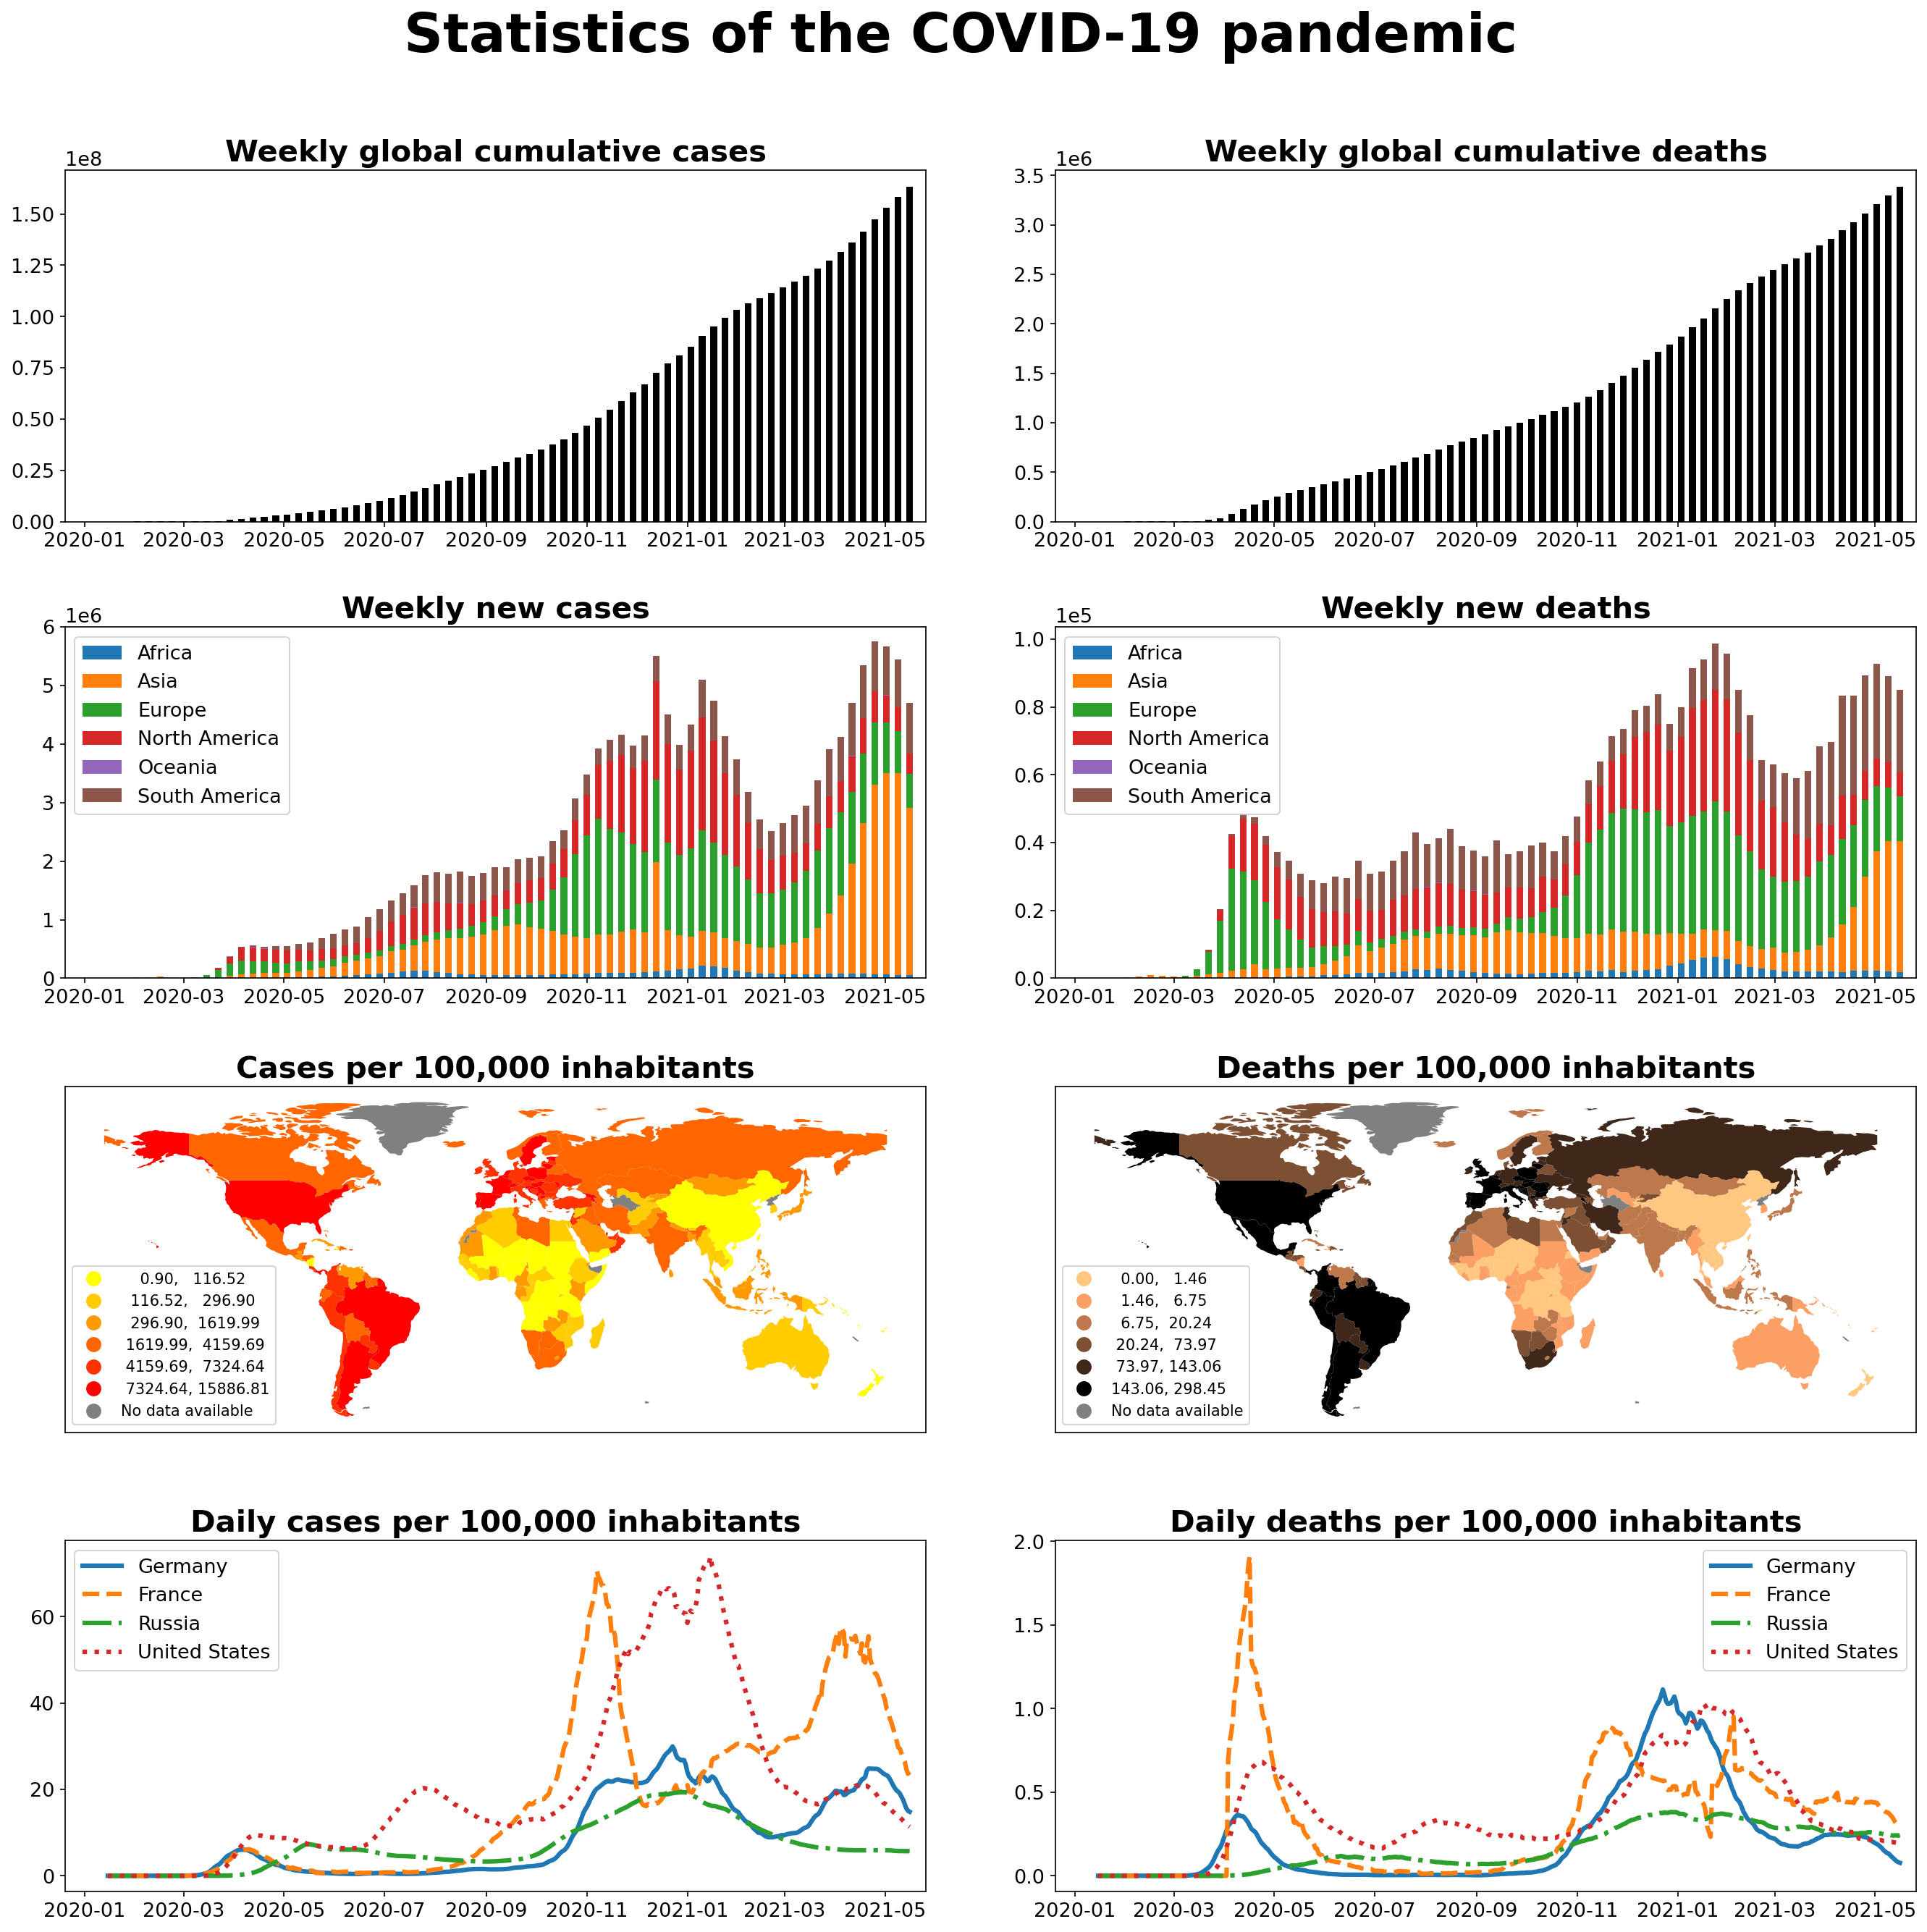

In [41]:
pathAndFilename = OUTPUT_PATH + '/desc_stats_covid19.png'
fig.savefig(pathAndFilename, bbox_inches='tight', dpi=150)

Image(filename=pathAndFilename) 

<a id="SIRF_model_parameter_estimation_and_visualization"></a>
## SIRF model parameter estimation and visualization

In this section, the parameters of the SIRF model will be estimated by using historical data.

<a id="parameter_estimation"></a>
### Parameter estimation

**Data import**

In [36]:
dataLoader = cs.DataLoader("input")
jhuData = dataLoader.jhu(verbose=0)
populationData = dataLoader.population()
oxcgrtData = dataLoader.oxcgrt()

df = jhuData.raw.drop_duplicates('Country')
countriesDict = dict(zip(df['ISO3'], df['Country']))

**Hyperparameter estimation**  
A two step hyperparameter estimation will be deployed. In a first run, parameters will be estimated over the whole time series of available data. In a second run, the largest increase in government stringency will be identified and parameters will be estimated until this point in time. This approach allows comparisons which are central to this analysis. First, it is possible to compare parameter values before impositions of stringent government measures with the parameter values that persist to the current point in time. Second and most importantly, it allows to analyse the efficacy of government measures from a retrospective point of view. As parameter values will be trained on data before governmental interventions, it allows to evaluate the effective impact of imposed measures on the models parameters and whether those measures were successfully enforced by the government. NOTE: The following cell has already been run for 72 hours and estimation result were stored in the folder 'retrospective'.

In [ ]:
# Defining the directory to store the estimated parameters
backupfileDict = cs.Filer(directory='retrospective')

files = [x[:3] for x in os.listdir('retrospective')]

for iCountry in tqdm(countriesDict):
    
    if iCountry not in files:
        
        try:
            
            # Instantiation of the country object.
            exec(f'{iCountry} = cs.Scenario(country="{countriesDict[iCountry]}")')
            eval(iCountry).register(jhuData, extras=[oxcgrtData])

            # S-R relationship analysis
            eval(iCountry).trend(show_figure = False)

            # Minimum of 90 days for parameter estimation.
            df = eval(iCountry).records(variables='all', show_figure=False).tail(-90)

            # Identification of largest stringency increase.
            iMax = np.argmax(np.diff(df['Stringency_index']))
            date = df.iloc[iMax, :]['Date']
            row = eval(iCountry).summary()[eval(iCountry).summary().apply(lambda k: datetime.strptime(k[1],'%d%b%Y') <= date <= datetime.strptime(k[2],'%d%b%Y'), axis=1)]
            beginningDate = row['End'][0]

            # Parameter estimation
            eval(iCountry).retrospective(beginning_date=beginningDate, model=cs.SIRF, control="Main", target="Retrospective", timeout=180)
            
            # JSON serialization
            eval(iCountry).backup(**backupfileDict.json(f'{iCountry}'))

        except:
            
            continue

<a id="data_inspection"></a>
### Data inspection

After having computed the model parameters for each country, we can have a first look at the estimation results which will give us a first intuition of how the target variables may be distributed.

**Loading estimations**

In [49]:
retrospective = {}

for iFile in tqdm(os.listdir('../data/retrospective')):
    
    if iFile.endswith('json'):
        
        country = iFile[:3]
        
        try:
            
            exec(f'{country} = cs.Scenario(country="{countriesDict[country]}")')
            eval(country).register(jhuData, extras=[oxcgrtData])
            eval(country).restore(f'../data/retrospective/{country}.json')
            
            continent = pc.country_alpha2_to_continent_code(pyc.countries.get(alpha_3=country).alpha_2)
            
            dic = retrospective.get(continent, {})
            dic.update({country:eval(country)})
            retrospective[continent] = dic

        except:
            
            continue

100%|██████████| 155/155 [12:04<00:00,  4.67s/it]


**Confirmed cases**  
First, we visualize the confirmed cases.

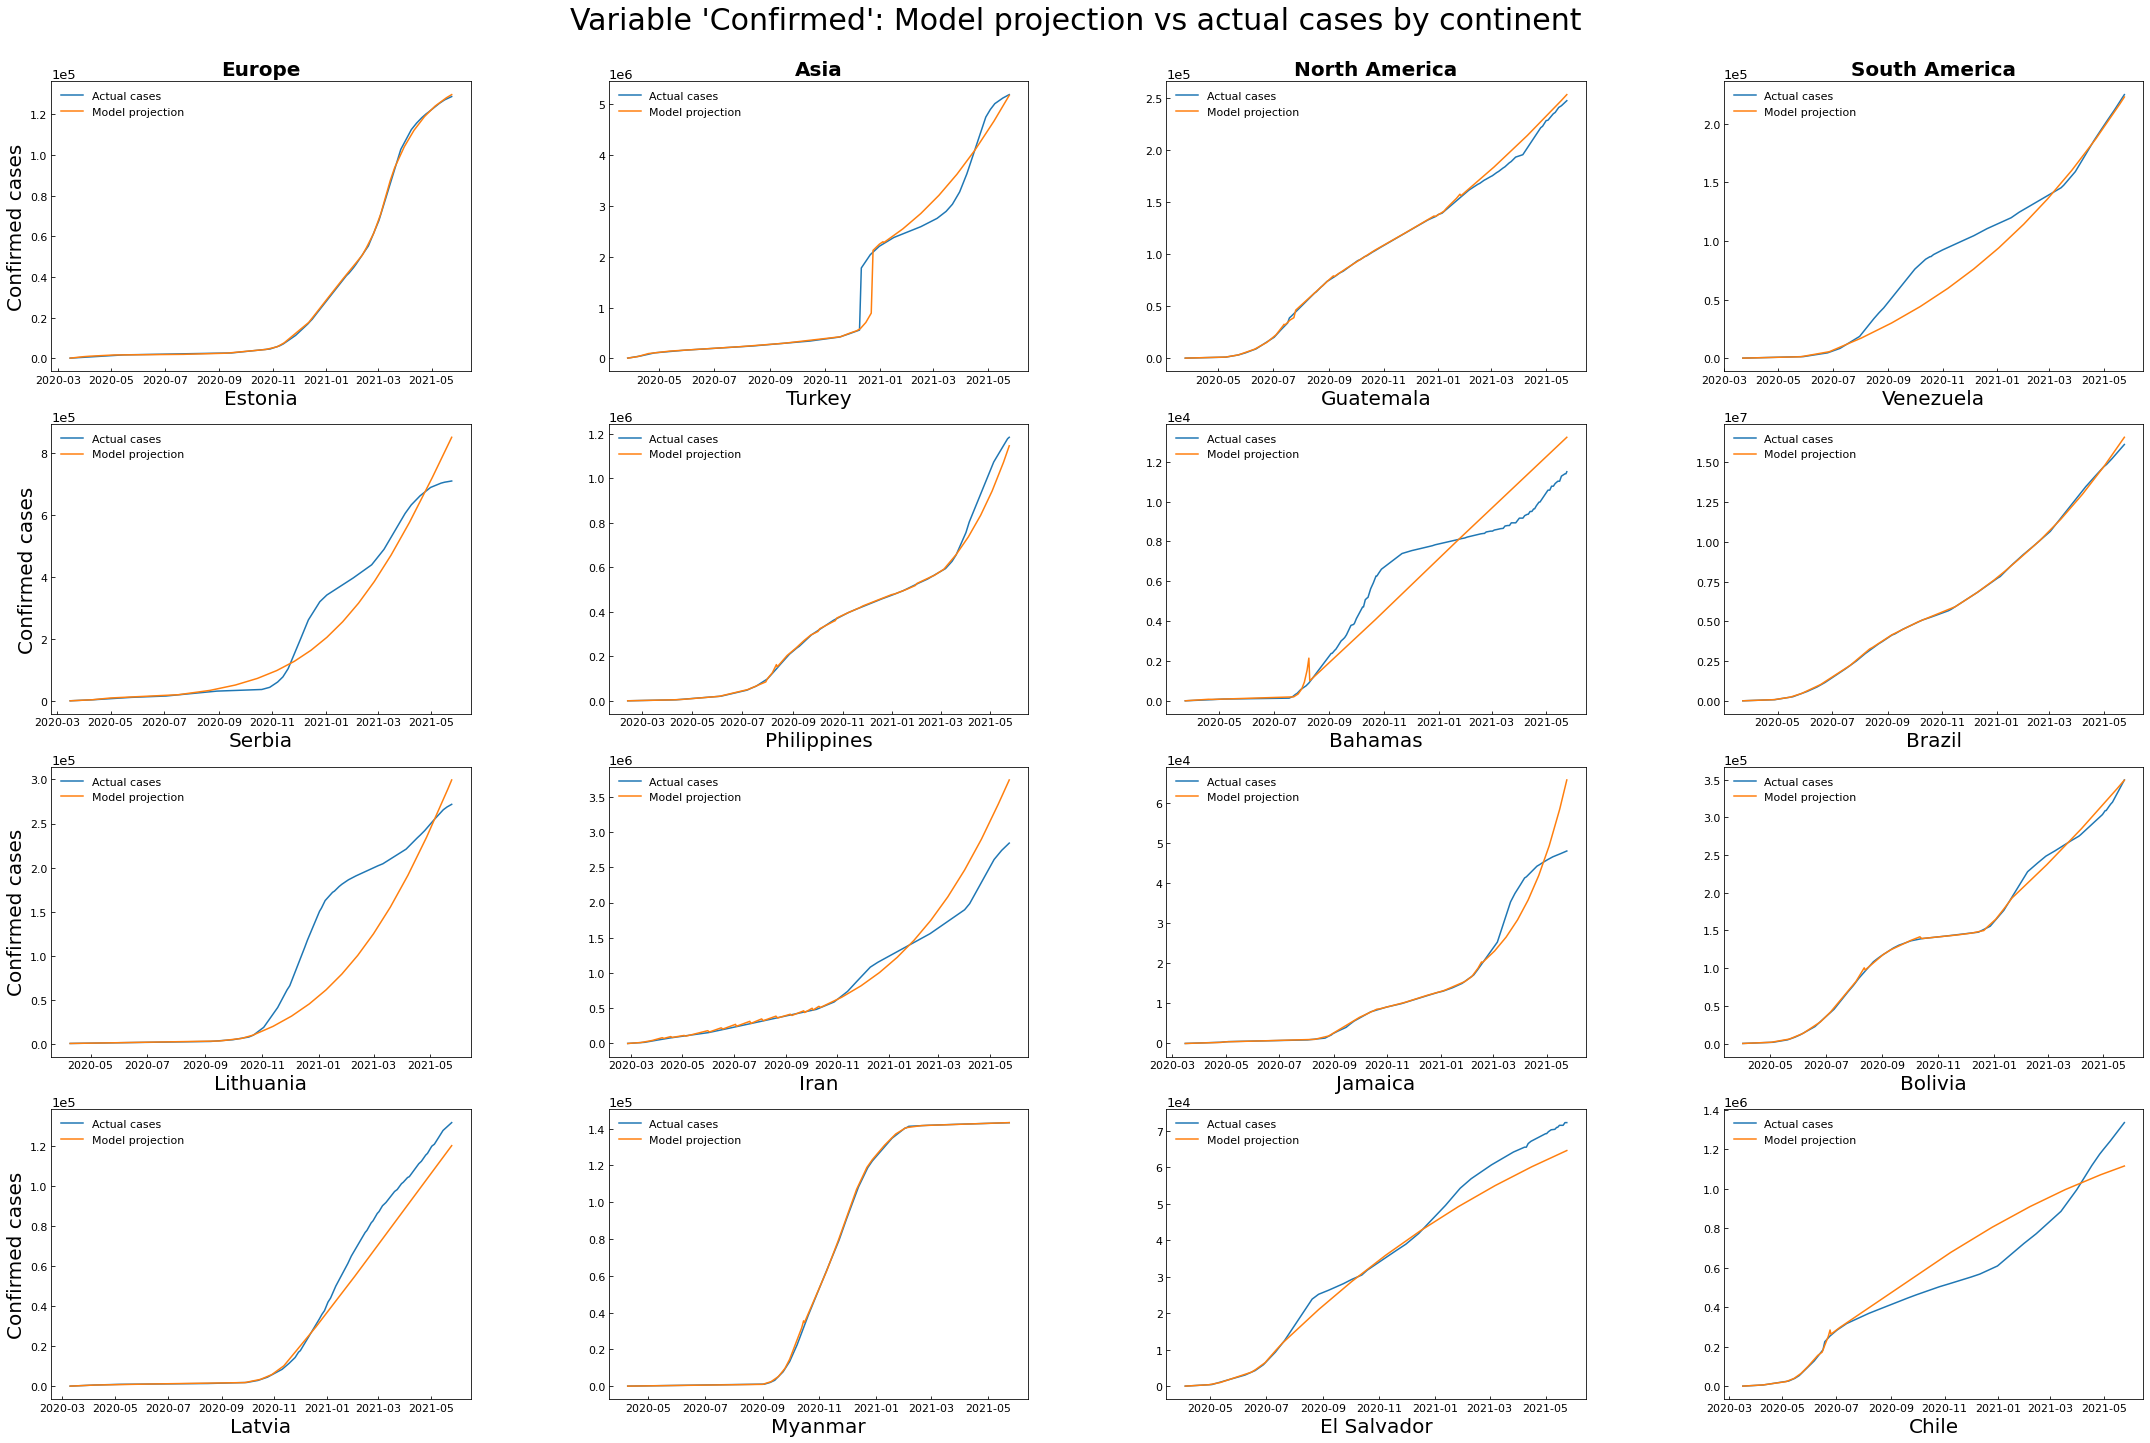

In [52]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Confirmed cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Confirmed', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Confirmed': Model projection vs actual cases by continent", size=30, y=1.001)
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

**Fatal cases**  
Next, we plot the deadly cases.

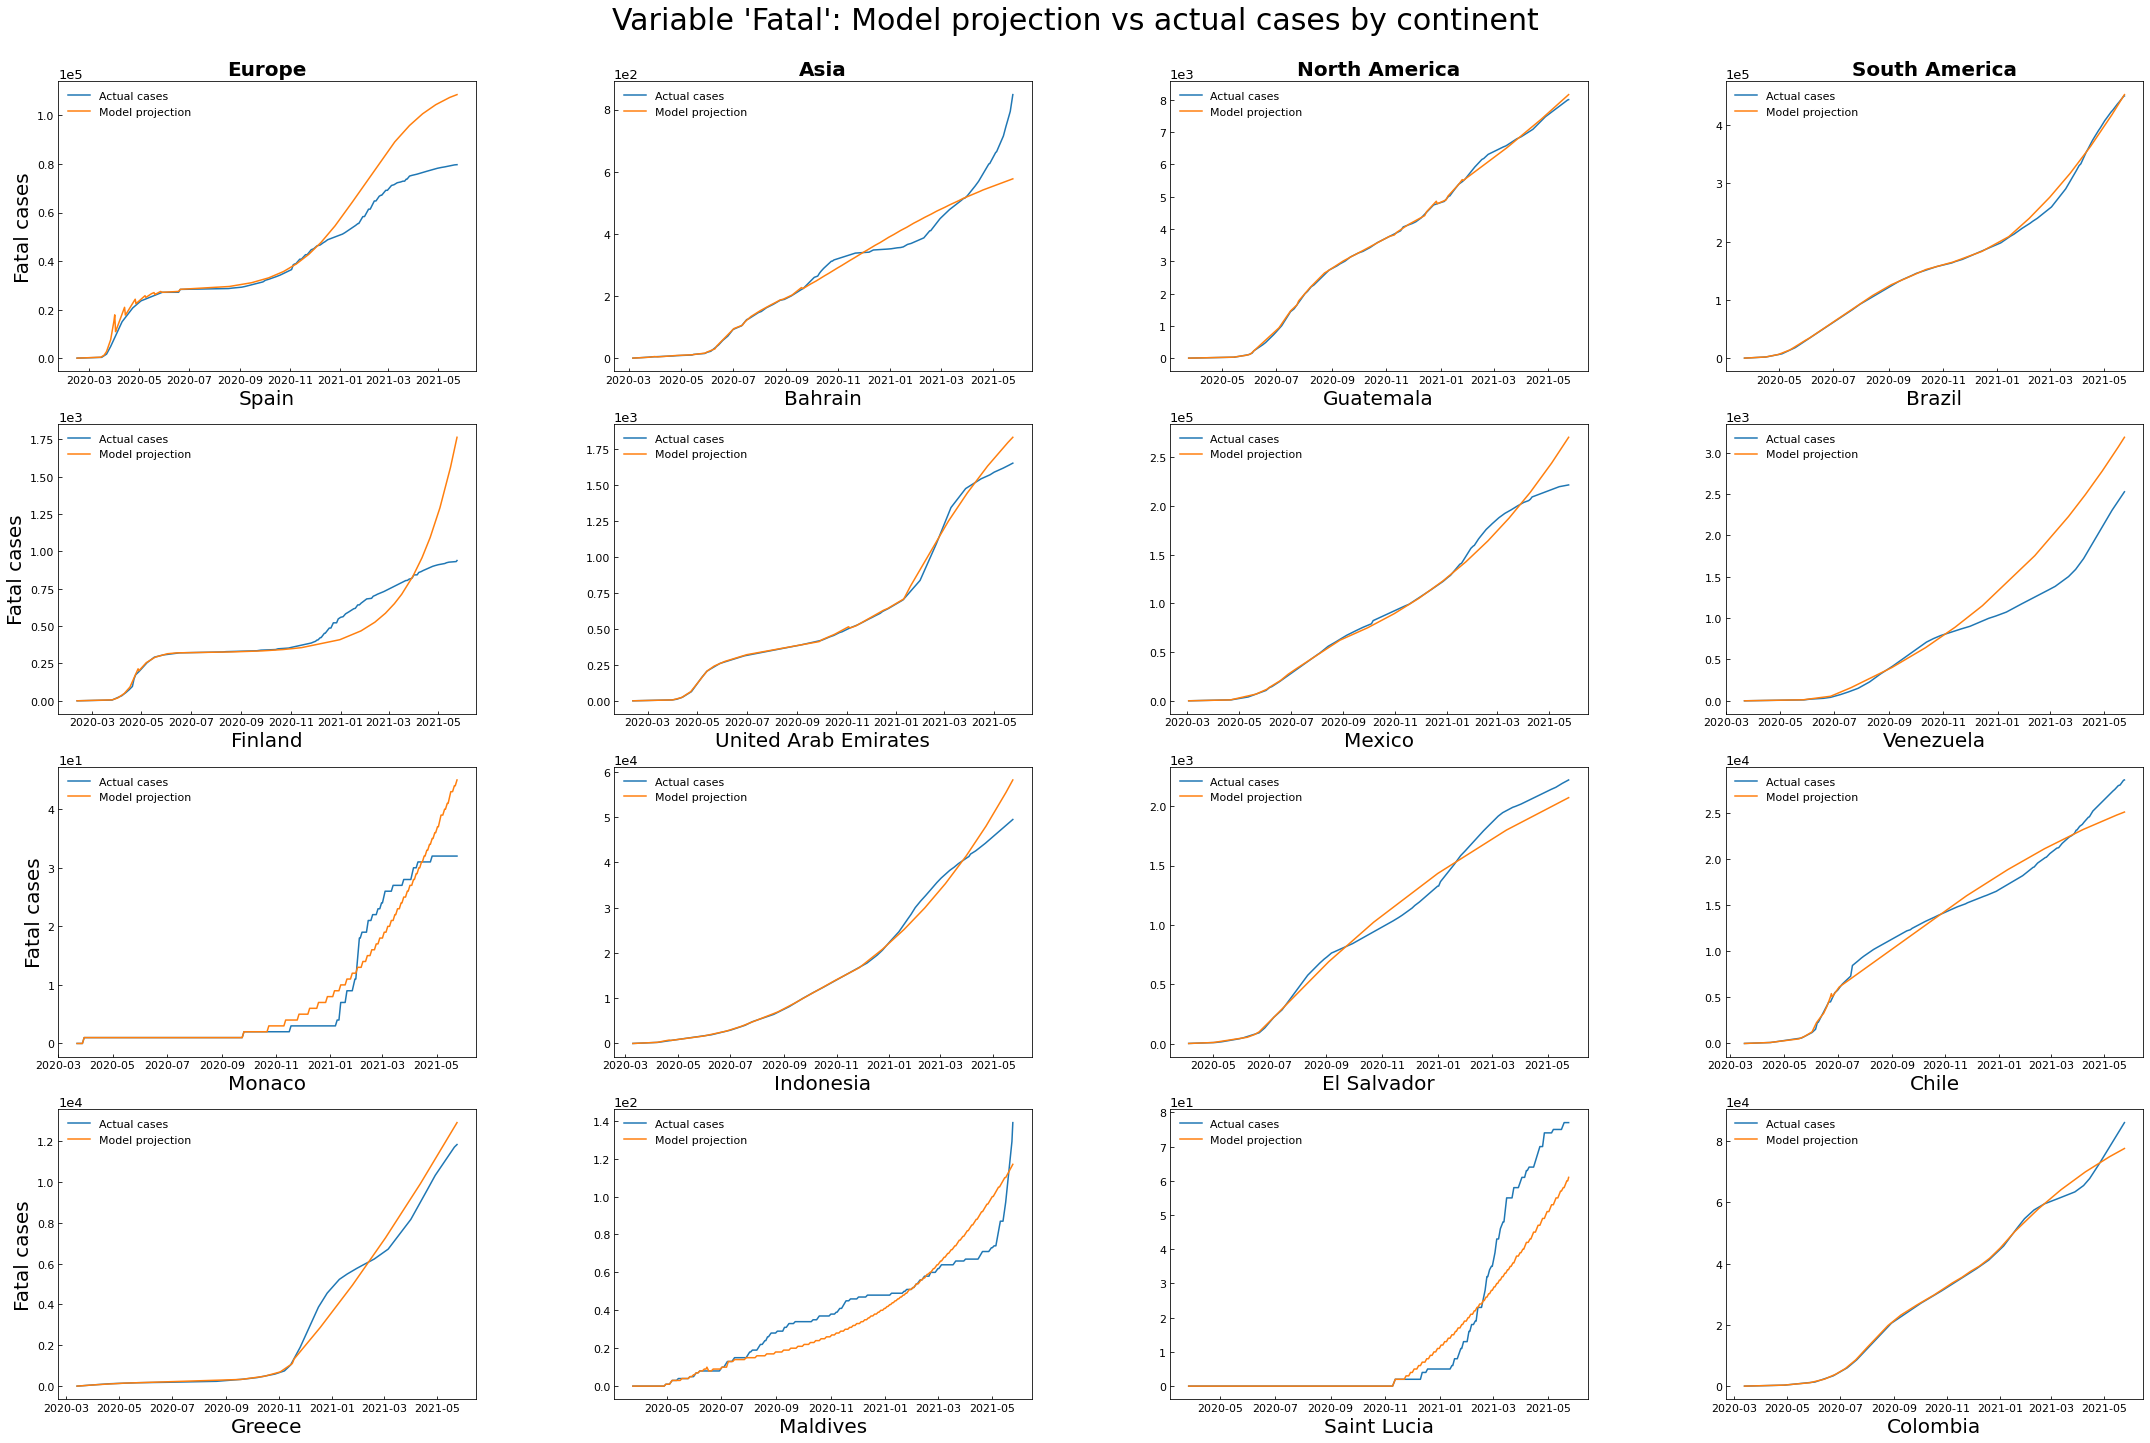

In [53]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Fatal cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Fatal', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Fatal': Model projection vs actual cases by continent", size=30, y=1.001)
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

**Recovered cases**  
Finally, we investigate the recovered cases.

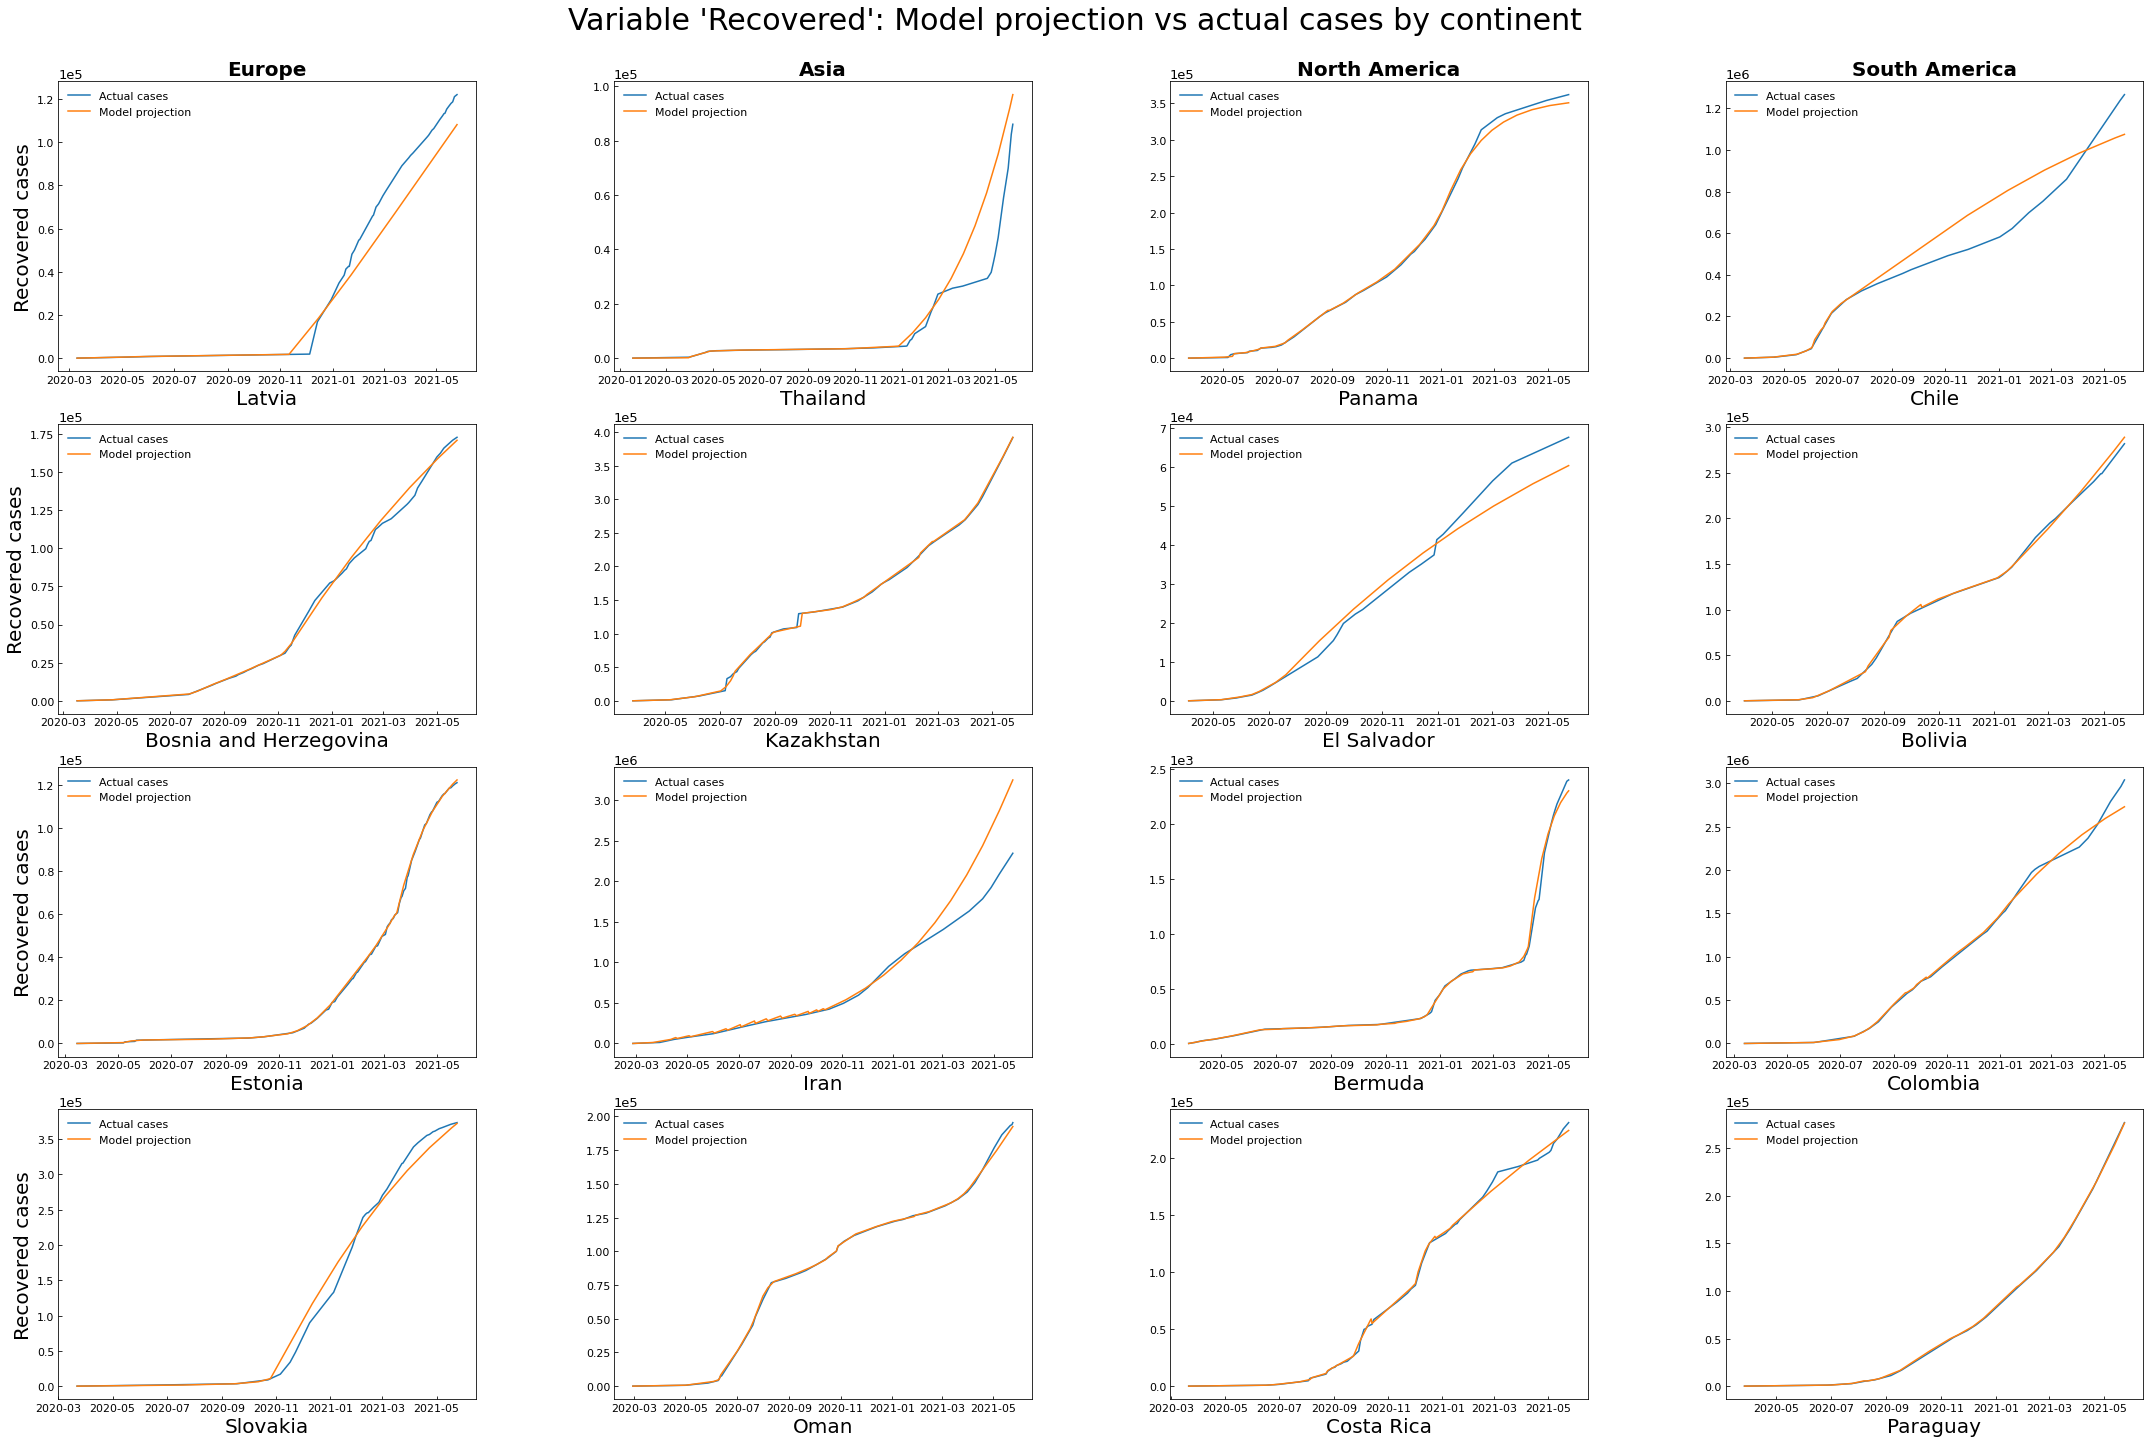

In [54]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Recovered cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Recovered', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Recovered': Model projection vs actual cases by continent", size=30, y=1.001)
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

<a id="effect_of_government_quality_on efficacy_of_government_interventions"></a>
## Effect of government quality on efficacy of government interventions

This subsection provides the econometric analysis that evaluates the efficacy of government intervention. First, the length of a window is defined over which the analysis will be conducted. Second, the difference between actual cases and simulated cases will be evaluated. Last, the difference will be regressed on variables related to government efficacy.

<a id="setup"></a>
### Set-up

**Definition of time window**  
We define a 90-day time window over which we compute the difference between the model projection and actual cases.

In [55]:
window = 90

In [56]:
analysis = {}
    
for iCountry in tqdm(countriesDict):
    
    try:
        
        df = eval(iCountry).records(variables='all', show_figure=False).tail(-90)
        iMax = np.argmax(np.diff(df['Stringency_index']))
        date = df.iloc[iMax, :]['Date']
        row = eval(iCountry).summary()[eval(iCountry).summary().apply(lambda k: datetime.strptime(k[1],'%d%b%Y') <= date <= datetime.strptime(k[2],'%d%b%Y'), axis=1)]
        beginningDate = row['End'][0]

        df = eval(iCountry).summary()
        endDate = df.loc['Main'].iloc[-1]['End']

        if (datetime.strptime(endDate, '%d%b%Y') - datetime.strptime(beginningDate, '%d%b%Y')).days >= window:
            analysis[iCountry] = datetime.strptime(beginningDate, '%d%b%Y')
    except:
        
        continue

100%|██████████| 197/197 [03:21<00:00,  1.02s/it]


**Calculation of dependent variable**

The efficacy of government measures manifests itself in the actual infection and fatal cases compared to what could have been, if the government did not intervene. The formula for estimating the dependent variable for the regressions is shown below.

$$ \text{Dependent Variable} = \sum_{t=1}^{90}(log_{10}(A_{t} + 1) - log_{10}(P_{t} + 1))^2 $$

In [57]:
dependentVariable = {}
    
for iCountry in tqdm(analysis):

    dependentVariable[iCountry] = {}

    try:
        
        dfConfirmed = eval(iCountry).history(target='Confirmed', show_figure=False)[['Actual', 'Retrospective']].loc[analysis[iCountry]:analysis[iCountry]+timedelta(days=window)]
        dfInfected = eval(iCountry).history(target='Infected', show_figure=False)[['Actual', 'Retrospective']].loc[analysis[iCountry]:analysis[iCountry]+timedelta(days=window)]
        dfFatal = eval(iCountry).history(target='Fatal', show_figure=False)[['Actual', 'Retrospective']].loc[analysis[iCountry]:analysis[iCountry]+timedelta(days=window)]
        dfRecovered = eval(iCountry).history(target='Recovered', show_figure=False)[['Actual', 'Retrospective']].loc[analysis[iCountry]:analysis[iCountry]+timedelta(days=window)]

        dependentVariable[iCountry]['Confirmed'] = dfConfirmed
        dependentVariable[iCountry]['Infected'] = dfInfected
        dependentVariable[iCountry]['Fatal'] = dfFatal
        dependentVariable[iCountry]['Recovered'] = dfRecovered

    except:
        continue

100%|██████████| 94/94 [05:44<00:00,  3.67s/it]


In [58]:
dfs = ['Confirmed', 'Infected', 'Fatal', 'Recovered']

for iDf in dfs:
    
    indices = []
    
    exec(f"{iDf}_diffs = []")
    exec(f"{iDf} = pd.DataFrame()")

    for iCountry in analysis:

        exec(f"{iDf}_diff = ((np.log(dependentVariable[iCountry]['{iDf}']['Actual'] + 1) - np.log(dependentVariable[iCountry]['{iDf}']['Retrospective'] + 1))**2).sum()")
        indices.append(iCountry)
        exec(f"{iDf}_diffs.append({iDf}_diff)")

    exec(f"{iDf}['Difference'] = {iDf}_diffs")
    exec(f"{iDf}['Country'] = indices")
    exec(f"{iDf}['Continent'] = {iDf}['Country'].apply(lambda k: pc.country_alpha2_to_continent_code(pyc.countries.get(alpha_3=k).alpha_2) if pyc.countries.get(alpha_3=k) != None else k).values")
    exec(f"{iDf} = {iDf}.set_index(['Continent', 'Country'])")
    exec(f"{iDf} = {iDf}.sort_index()")

**Distributions of the dependent variable**

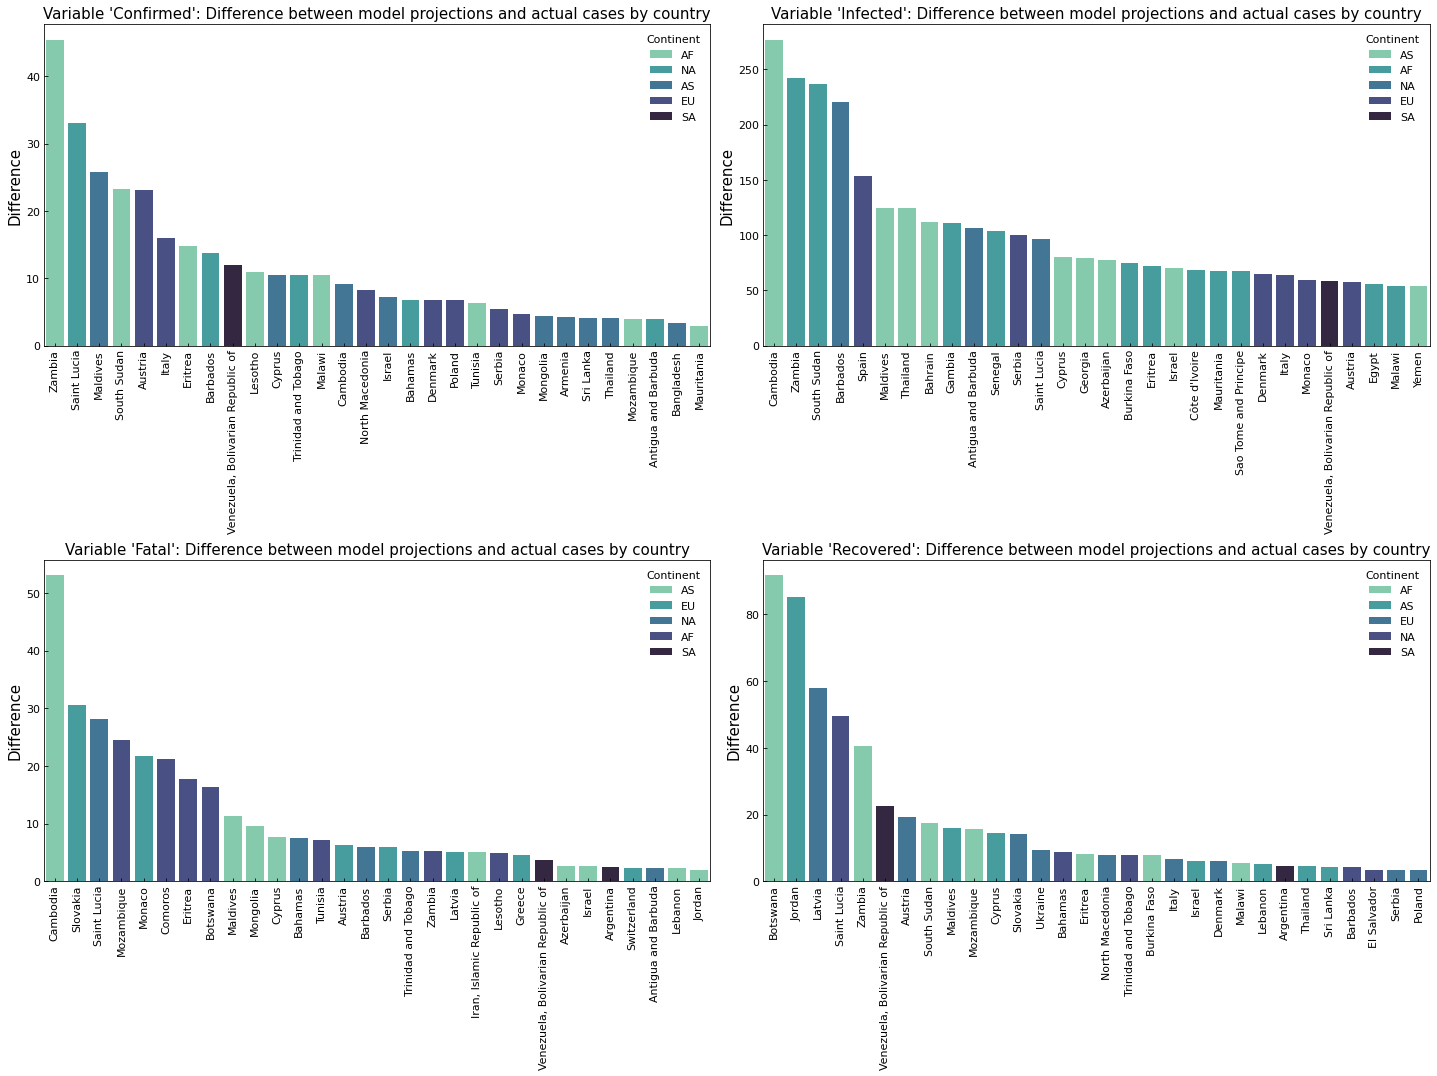

In [143]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

for iIteration, iAx in enumerate(axes.flat):

    sns.barplot(data=eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).head(30), x='Country', y='Difference', hue='Continent', dodge=False, ax=iAx, palette=sns.color_palette('mako_r', 5))
    iAx.set_xticklabels(eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).head(30)['Country'].apply(lambda k: pyc.countries.get(alpha_3=k).name))
    iAx.tick_params(axis='x', labelrotation=90)
    iAx.set_title(f"Variable '{dfs[iIteration]}': Difference between model projections and actual cases by country", size=15)
    iAx.set_ylabel('Difference', size=15) 
    iAx.set_xlabel(None) 
    
fig.tight_layout(pad=0.8)

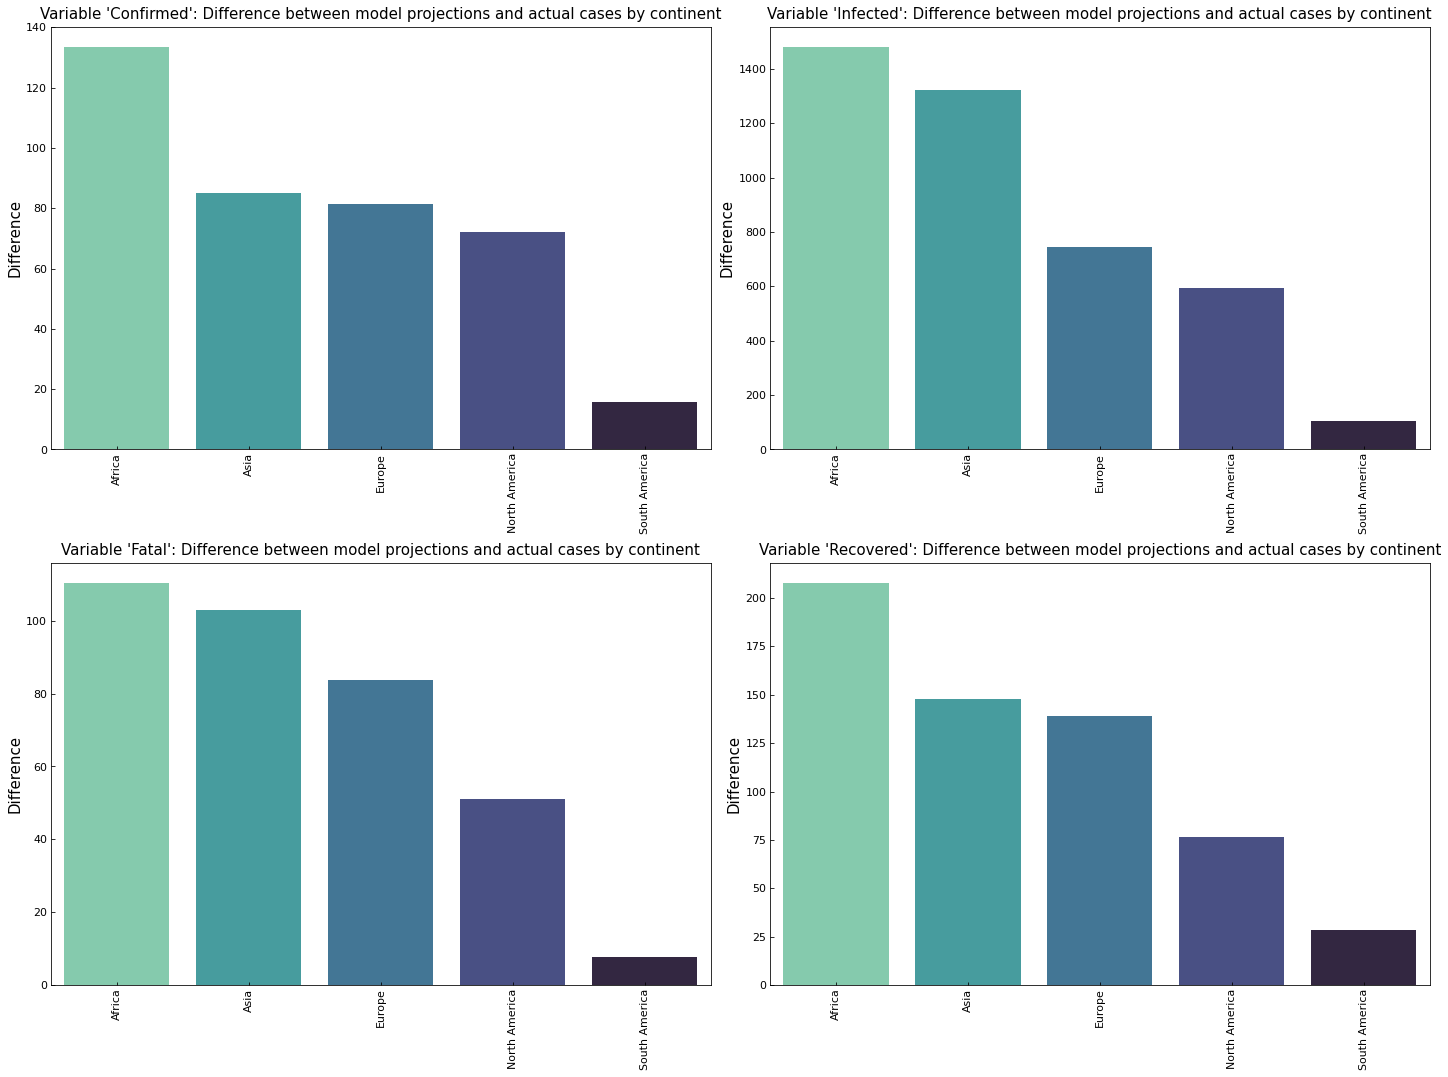

In [145]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

for iIteration, iAx in enumerate(axes.flat):

    sns.barplot(data=eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index(), x='Continent', y='Difference', ax=iAx, errwidth=0, palette=sns.color_palette('mako_r', 5))
    iAx.set_xticklabels(eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.tick_params(axis='x', labelrotation=90)
    iAx.set_title(f"Variable '{dfs[iIteration]}': Difference between model projections and actual cases by continent", size=15, y=1.005)
    iAx.set_ylabel('Difference', size=15)
    iAx.set_xlabel(None)
    
fig.tight_layout(pad=0.8)

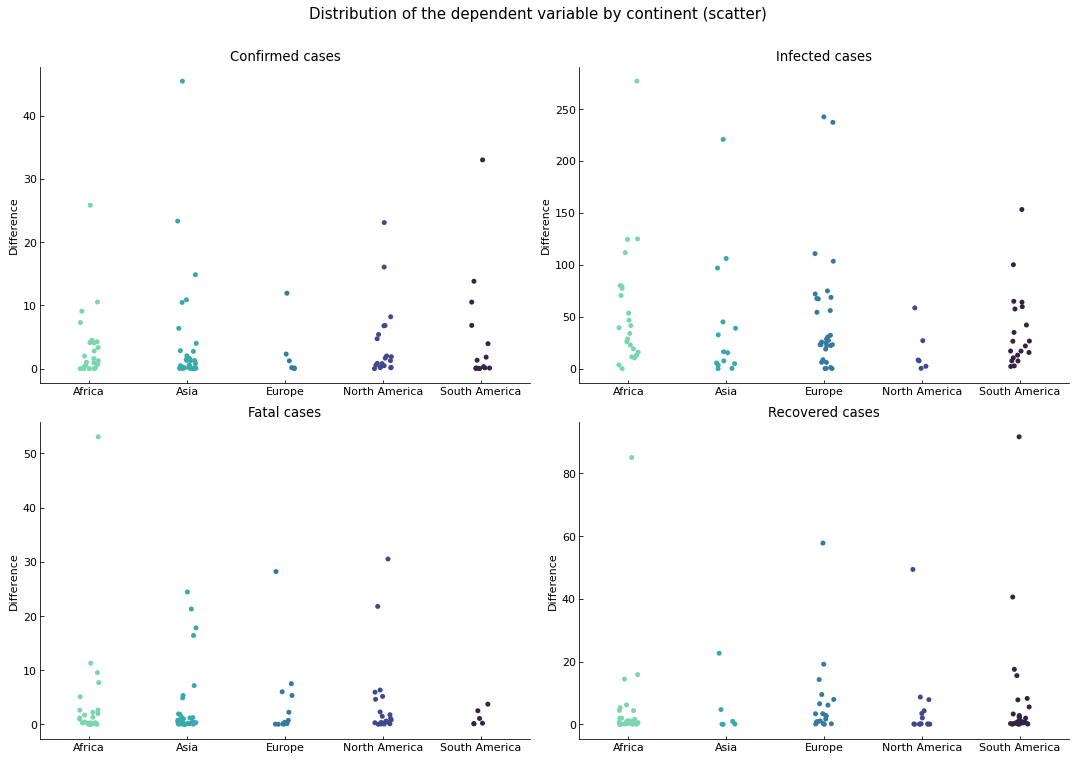

In [138]:
for iIteration, iDf in enumerate(dfs):
    exec(f"g{iIteration} = sns.catplot(data=eval(iDf).reset_index().sort_values('Difference'), x='Continent', y='Difference', height=7, palette=sns.color_palette('mako_r', 5))")

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

for iIteration, iGrid in enumerate(gs):
    exec(f"mg{iIteration} = sfg.SeabornFig2Grid(g{iIteration}, fig, iGrid)")
    
for iIteration, iAx in enumerate(fig.axes):
    iAx.set_title(f"{dfs[iIteration]} cases")
    iAx.set_xticklabels(eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.set_xlabel(None)
    
gs.tight_layout(fig, pad=0.8)
fig.suptitle('Distribution of the dependent variable by continent (scatter)', size=15, y=1.05)
plt.show()

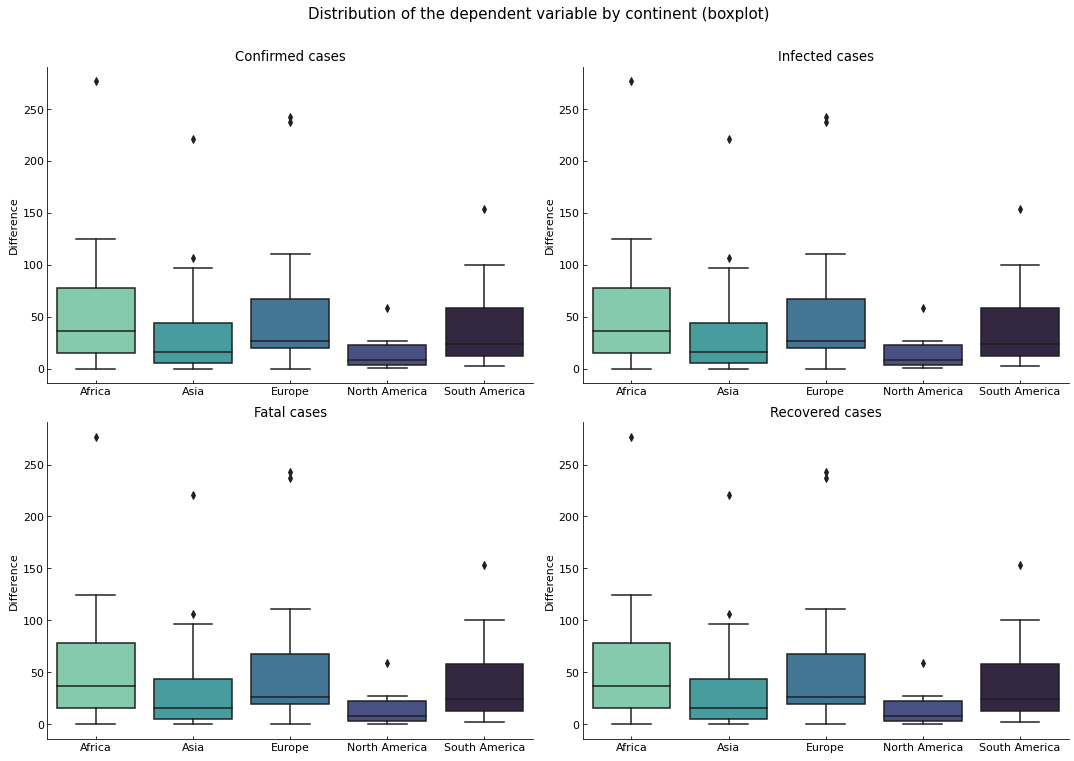

In [140]:
for iIteration, iDf in enumerate(dfs):
    exec(f"g{iIteration} = sns.catplot(data=Infected.reset_index().sort_values('Difference'), x='Continent', y='Difference', kind='box', height=7, palette=sns.color_palette('mako_r', 5))")

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

for iIteration, iGrid in enumerate(gs):
    exec(f"mg{iIteration} = sfg.SeabornFig2Grid(g{iIteration}, fig, iGrid)")
    
for iIteration, iAx in enumerate(fig.axes):
    iAx.set_title(f"{dfs[iIteration]} cases")
    iAx.set_xticklabels(eval(dfs[iIteration]).reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.set_xlabel(None)
    
gs.tight_layout(fig, pad=0.8)
fig.suptitle('Distribution of the dependent variable by continent (boxplot)', size=15, y=1.05)
plt.show()

**Regressor dataset**

A comprehensive collection of datasets from the Quality of Government Institute (QoG) from the University of Gothenburg is used to identify the regressors for our analysis. The QoG researchers developed the original datasets, which focuses on themes such as government quality, openness, and public administration. Data is supplied on a micro and subnational level. More information about the QoG as data source can be found on [their website](https://www.gu.se/en/quality-government/qog-data).

In [148]:
# Import of quality of governance dataset
qdf = pd.read_excel('../data/raw_data/qog_std_cs_jan21.xlsx')
qdf = qdf.set_index('ccodealp').drop(columns=['ccode', 'cname', 'ccodewb', 'version', 'ccodecow'])

cols = set([iCol.split('_')[0] for iCol in qdf.columns])
datasets = {}

for iCol in cols:
    datasets[iCol] = {}
    datasets[iCol]['regressors'] = qdf[qdf.columns[qdf.columns.str.startswith(iCol)]]

<a id="multiple_linear_regression_model"></a>
### Multiple linear regression model

The first model is a multiple linear regression that is estimated with OLS. We select the k=3 best regressors of the `wdi` dataset provided by the QoG.

In [149]:
modelsDict = {}

In [150]:
reg = pd.merge(Confirmed, datasets['wdi']['regressors'], left_on=['Country'], right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

selector = SelectKBest(f_regression, k=3)
selector.fit_transform(X, Y)
Xnew = X.iloc[:,selector.get_support(indices=True)]

reg = reg[['Difference']+ Xnew.columns.tolist()]

model = sm.OLS(Y, sm.add_constant(Xnew)).fit()
modelsDict['Linear model'] = {}
modelsDict['Linear model']['model'] = model
modelsDict['Linear model']['reg'] = reg
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     7.989
Date:                Sun, 30 May 2021   Prob (F-statistic):           8.85e-05
Time:                        20:27:22   Log-Likelihood:                -310.75
No. Observations:                  94   AIC:                             629.5
Df Residuals:                      90   BIC:                             639.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              23.2802      6.309      3.690      0.000      10.747      35.814
wdi_infpay          0.1601      0.054      2.969      0.004       0.053       0.267
wdi_statcap         0.0178      0.071      0.252      0.801      -0.122       0.158
wdi_statcaptime    -0.2719      0.099     -2.758      0.007      -0.468      -0.076
==============================================================================
Omnibus:                       45.003   Durbin-Watson:                   2.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.299
Skew:                           1.751   Prob(JB):                     9.19e-26
Kurtosis:                       7.145   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model yields significant coefficients of the following variables:
- `wdi_infpay`: Informal payments to public officials.
- `wdi_popurb`: Urban population in percentage of total population.
- `wdi_statcaptime`: Periodicity and timeliness assessment of statistical capacity. This variable measures "the availability and periodicity of key socioeconomic indicators" ([IndexMundi (2019)](https://www.indexmundi.com/facts/indicators/IQ.SCI.PRDC)).

<a id="multiple_linear_regression_model_with_continent_fixed_effects"></a>
### Multiple linear regression model with continent fixed effects

The second model is a multiple regression in linear form with continent fixed effects. We select the k=3 best regressors of the `wdi` dataset provided by the QoG.

In [151]:
continentsDict = ['AF', 'AS', 'EU', 'NA', 'SA']
dummiesList = [f'Continent_{c}' for c in continentsDict]

In [152]:
reg = pd.merge(Confirmed, datasets['wdi']['regressors'], left_on=['Country'], right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

selector = SelectKBest(f_regression, k=3)
selector.fit_transform(X, Y)
Xnew = X.iloc[:,selector.get_support(indices=True)]

reg = reg[['Difference']+ Xnew.columns.tolist()]

model = smf.ols(formula = 'Difference ~ ' + ' + '.join(Xnew.columns) + ' + ' + ' + '.join(dummiesList), data=pd.get_dummies(reg.reset_index(), columns=['Continent'])).fit()
modelsDict['Fixed effects model'] = {}
modelsDict['Fixed effects model']['model'] = model
modelsDict['Fixed effects model']['reg'] = reg
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     3.977
Date:                Sun, 30 May 2021   Prob (F-statistic):           0.000824
Time:                        20:27:34   Log-Likelihood:                -308.66
No. Observations:                  94   AIC:                             633.3
Df Residuals:                      86   BIC:                             653.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          21.7172      5.572      3.898      0.000      10.641      32.794
wdi_infpay          0.1899      0.056      3.381      0.001       0.078       0.302
wdi_statcap        -0.0372      0.076     -0.488      0.627      -0.189       0.114
wdi_statcaptime    -0.2587      0.101     -2.565      0.012      -0.459      -0.058
Continent_AF        1.4931      1.620      0.922      0.359      -1.727       4.713
Continent_AS        4.3456      1.716      2.533      0.013       0.935       7.756
Continent_EU        5.1200      1.824      2.807      0.006       1.494       8.746
Continent_NA        5.2576      1.855      2.835      0.006       1.570       8.945
Continent_SA        5.5010      2.868      1.918      0.058      -0.199      11.201
==============================================================================
Omnibus:                       42.311   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.706
Skew:                           1.682   Prob(JB):                     2.23e-22
Kurtosis:                       6.760   Cond. No.                     1.25e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.46e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The model yields significant coefficients of the following variables, whereby the continent fixed effects are also highly significant:
- `wdi_infpay`: Informal payments to public offcials
- `wdi_popurb`: Urban population in percentage of total population
- `wdi_statcaptime`: Periodicity and timeliness assessment of statistical capacity. This variable measures "the availability and periodicity of key socioeconomic indicators" ([IndexMundi (2019)](https://www.indexmundi.com/facts/indicators/IQ.SCI.PRDC)).

<a id="multiple_linear_regression_model_with_interaction_effects"></a>
### Multiple linear regression model with interaction effects

The last model is a multiple regression with interaction effects. We select the k=1 best regressor of the `gggi`dataset provided by the QoG.

In [154]:
reg = pd.merge(Confirmed, datasets['gggi']['regressors'], left_on=['Country'], right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

Xint = pd.DataFrame(PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(X), columns = list(X.columns) + list(itertools.combinations(X.columns, 2)))
Xint.index = Y.index
selector = SelectKBest(f_regression, k=1)
selector.fit_transform(Xint, Y)
Xint = Xint.iloc[:,selector.get_support(indices=True)]
Xint.columns = [x[0] + '_' + x[1] if type(x) == tuple else x for x in Xint.columns]

reg = pd.merge(Y, Xint, left_index=True, right_index=True)

model = smf.ols(formula = 'Difference ~ ' + ' + '.join(Xint.columns), data=reg.reset_index()).fit()
modelsDict['Interaction model'] = {}
modelsDict['Interaction model']['model'] = model
modelsDict['Interaction model']['reg'] = reg
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     46.26
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.02e-09
Time:                        20:27:53   Log-Likelihood:                -302.70
No. Observations:                  94   AIC:                             609.4
Df Residuals:                      92   BIC:                             614.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2734      0.644      5.084      0.000       1.995       4.552
gggi_eas_gggi_ggi     0.6165      0.091      6.802      0.000       0.436       0.797
==============================================================================
Omnibus:                       71.986   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.415
Skew:                           2.654   Prob(JB):                     2.41e-73
Kurtosis:                      10.564   Cond. No.                         7.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model yields significant coefficients for the following variables:
- `gggi_eas`: Global Gender Gap Educational Attainment Subindex
- `gggi_ggi`: Overall Global Gender Gap Index

<a id="regression_diagnostics"></a>
### Regression diagnostics

**Normal Q-Q Plot**  
With the Q-Q plot, we can check the normality assumption of the dependent variable.

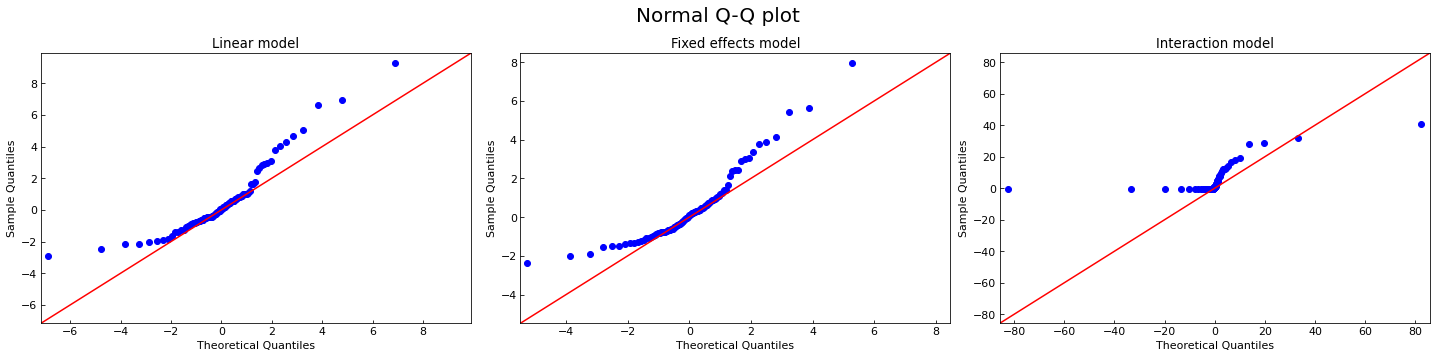

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for iIteration, iModel in enumerate(modelsDict):
    
    sm.qqplot(modelsDict[iModel]['model'].resid, stats.t, distargs=(4,), fit=True, ax=axes[iIteration], line='45')
    axes[iIteration].set_title(iModel)

fig.suptitle('Normal Q-Q plot', size=20)
fig.tight_layout(pad=0.8)

The assumption seems to be more plausible for the first two regression models, however less plausible for the third regression model.

**Scale-Location test**

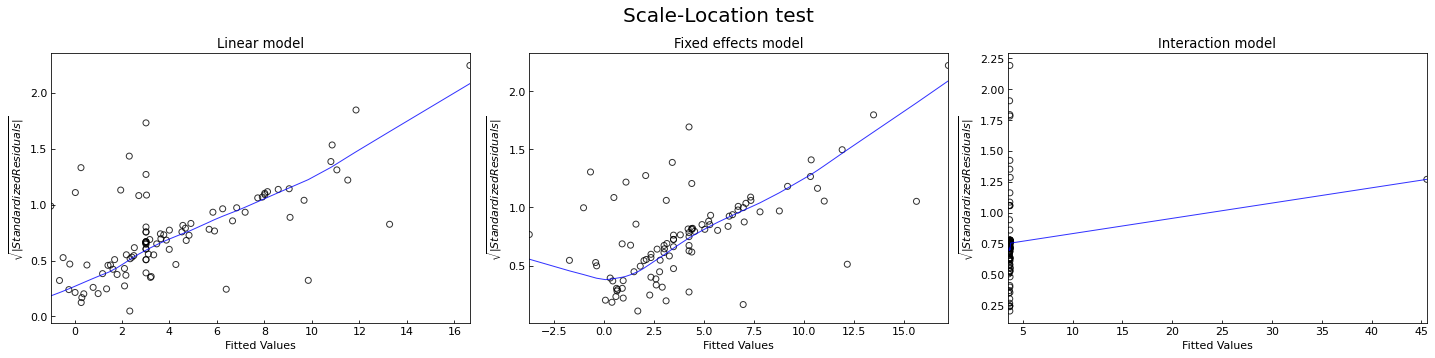

In [156]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for iIteration, iModel in enumerate(modelsDict):
    
    sns.regplot(modelsDict[iModel]['model'].fittedvalues, 
           np.sqrt(np.abs(modelsDict[iModel]['model'].get_influence().resid_studentized_internal)), 
            scatter=True, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8},
          scatter_kws={'facecolors':'none', 'edgecolors':'black'}, ax=axes[iIteration])
    axes[iIteration].set_title(iModel)
    axes[iIteration].set_xlabel('Fitted Values')
    axes[iIteration].set_ylabel('$\sqrt{|Standardized Residuals|}$')

fig.suptitle('Scale-Location test', size=20)
fig.tight_layout(pad=0.8)

**Multicollinearity tests**

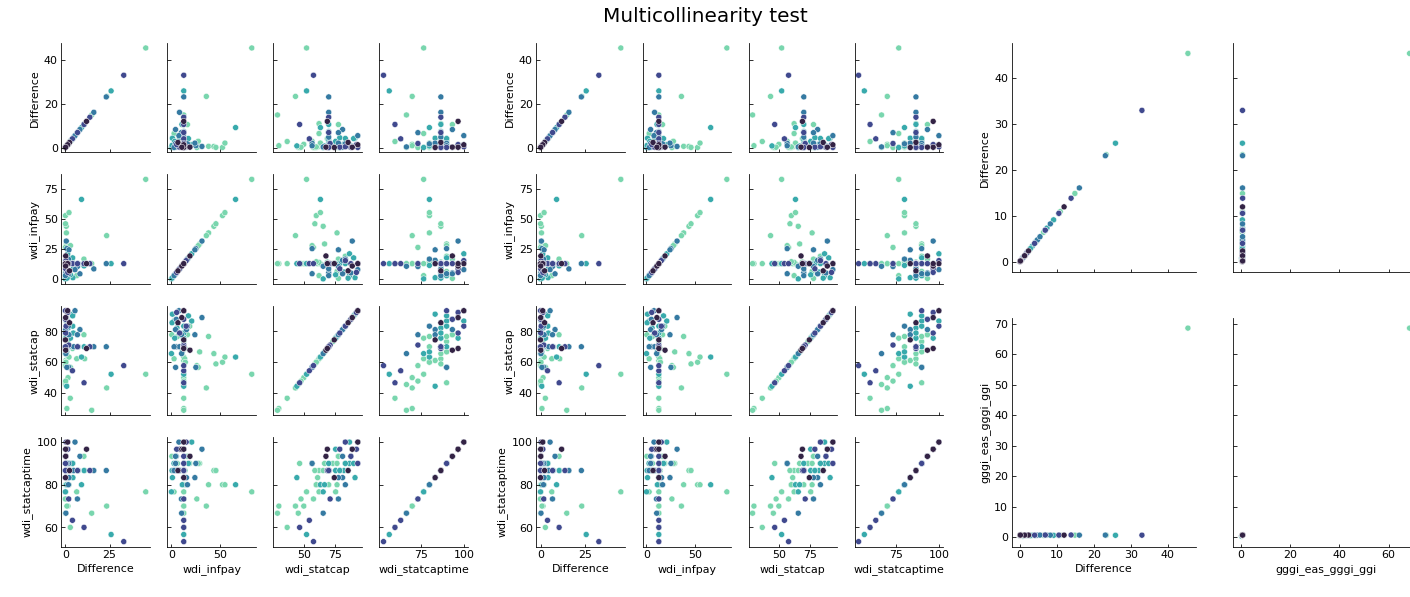

In [157]:
g0 = sns.PairGrid(modelsDict['Linear model']['reg'].reset_index(), hue='Continent', palette=sns.color_palette('mako_r', 5)).map(sns.scatterplot)
g1 = sns.PairGrid(modelsDict['Fixed effects model']['reg'].reset_index(), hue='Continent', palette=sns.color_palette('mako_r', 5)).map(sns.scatterplot)
g2 = sns.PairGrid(modelsDict['Interaction model']['reg'].reset_index(), hue='Continent', palette=sns.color_palette('mako_r', 5)).map(sns.scatterplot)

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3)

mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
mg2 = sfg.SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig, pad=2)
fig.suptitle('Multicollinearity test', size=20, y=1.05)
plt.show()

**Heteroscedasticity tests**

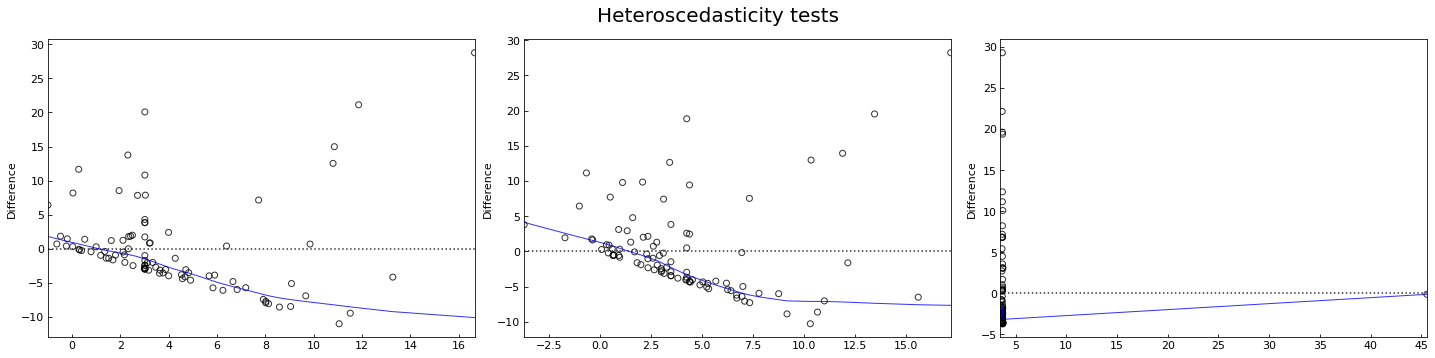

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for iIteration, iModel in enumerate(modelsDict):
    
    sns.residplot(modelsDict[iModel]['model'].fittedvalues, 'Difference', data=modelsDict[iModel]['reg'], lowess=True, 
                  scatter_kws={'facecolors':'none', 'edgecolors':'black'}, line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8}, ax=axes[iIteration])  

fig.suptitle('Heteroscedasticity tests', size=20)
fig.tight_layout(pad=0.8)

<a id="scenario_analysis"></a>
## Scenario analysis

The final section of the empirical analysis part provides simulations of COVID-19 numbers for Switzerland. We use the best trained parameters over the entire time series which is available and we estimate the scenario cases for the variables Confirmed, Infected, Fatal and Recovered. 

**Adding scenarios**

In [159]:
# Basis scenario
country = 'CHE'
eval(country).add(days=360, name="Basis")

# Lockdown scenario
rhoLockdown = eval(country).get("rho", phase="last") * 0.5
eval(country).add(days=360, name="Lockdown", rho=rhoLockdown)

# Medicine scenario
kappaMedicine = eval(country).get("kappa", phase="last") * 0.5
sigmaMedicine = eval(country).get("sigma", phase="last") * 2
eval(country).add(days=360, name="Medicine", kappa=kappaMedicine, sigma=sigmaMedicine)

# Vaccine scenario
rhoVaccine = eval(country).get("rho", phase="last") * 0.8
kappaVaccine = eval(country).get("kappa", phase="last") * 0.6
sigmaVaccine = eval(country).get("sigma", phase="last") * 1.2
eval(country).add(days=360, name="Vaccine",  rho=rhoVaccine, kappa=kappaVaccine, sigma=sigmaVaccine)

**Simulating scenarios**

In [160]:
# Simulate the number of cases
variables = {'C':'Confirmed', 'I':'Infected', 'F':'Fatal', 'R':'Recovered'}
scenarios = ['Basis', 'Lockdown', 'Medicine', 'Vaccine']

for iScenario in scenarios:
    exec(f"{iScenario} = eval(country).simulate(name='{iScenario}', variables = ['Confirmed', 'Infected', 'Fatal', 'Recovered'], show_figure=False)")

for iVariable in variables:
    
    exec(f"{iVariable} = eval(scenarios[0])[[variables[iVariable], 'Date']]")
    exec(f"{iVariable}.columns = ['Basis', 'Date']")
    
    for iScenario in scenarios[1:]:
        to_merge = eval(iScenario)[[variables[iVariable], 'Date']]
        to_merge.columns = [iScenario, 'Date']
        exec(f"{iVariable} = pd.merge({iVariable}, to_merge, left_on='Date', right_on='Date')")
    

**Visualization**

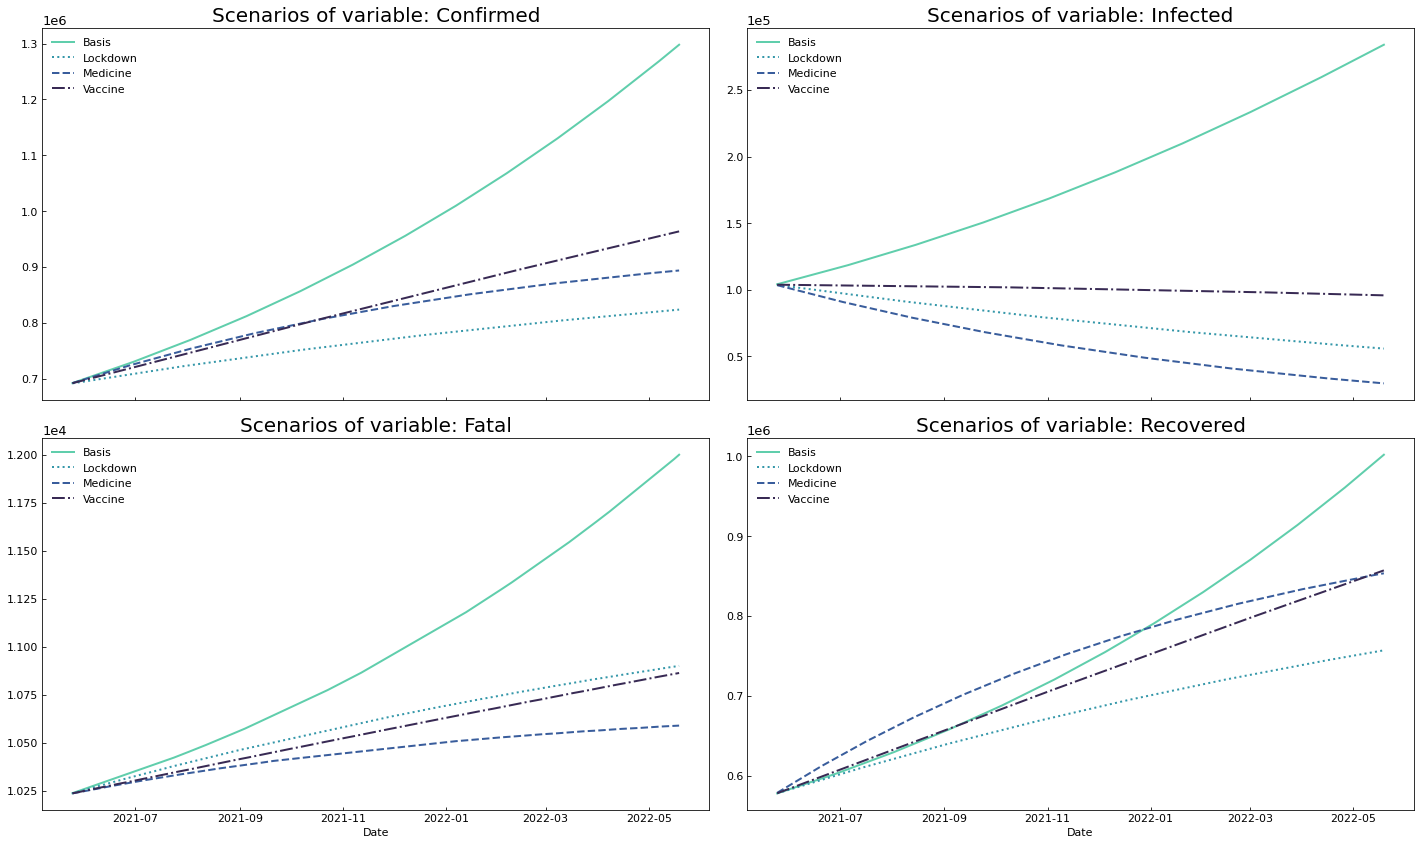

In [175]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12), sharex=True)

for iIteration, iVariable in enumerate(variables):
    
    df = eval(iVariable).tail(360)
    sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df, ['Date']), ax=eval(f'ax{iIteration}'), palette=sns.color_palette("mako_r", 4), sizes=10, linewidth=2)
    eval(f'ax{iIteration}.set_title("Scenarios of variable: {variables[iVariable]}", size=20)')
    eval(f'ax{iIteration}.set_ylabel(None)')
    eval(f'ax{iIteration}.ticklabel_format(axis="y", style="sci", scilimits=(0,0))')
    exec(f'exponent = ax{iIteration}.yaxis.get_offset_text()')
    eval(f'exponent.set_size(13)')
    
    for iLinestyle, iLine in eval(f"zip(('solid', 'dotted', 'dashed', 'dashdot'), ax{iIteration}.lines)"):
        iLine.set_linestyle(iLinestyle)
    
    eval(f"ax{iIteration}.legend([line for line in ax{iIteration}.lines], ['Basis', 'Lockdown', 'Medicine', 'Vaccine'])")

fig.tight_layout(pad=1.5)

<a id="conclusion"></a>
# Conclusion

In this study, we examined the impact of government quality on the efficiacy of government interventions and predicted how the coronavirus situation in Switzerland would change over the next 360 days if a lockdown would be imposed or drugs and vaccines would be administered in May 2021. We provide evidence that the government quality variables informal payments to officials and frequency of publication of key socioeconomic indicators have a significant impact on the efficiacy of coronavirus government interventions. Furthermore, our findings show that a lockdown, medicine and vaccine today would considerably curb the coronavirus epidemic in Switzerland over the next year.

Our results have important policy implications, namely that government interventions to dampen the spread of the coronavirus depend on the quality of the government and the coronavirus epidemic's negative impact on public health in Switzerland could be further alleviated if effective medicines would be available or another lockdown would be imposed.